HGBoost library as-known-as Hyper-Optimized Gradient Boosting; is a Python package that provides hyperparameter optimization for XGBoost, LightBoost and CatBoost. It divides the dataset into a train, test, and independent validation set. The train test set has inner loop to optimize hyperparameters using Bayesian optimization (using hyperopt) and outer loop to score how well the best performing models can generalize using k-fold cross validation. Such an approach has the advantage of choosing not only the model with the highest accuracy, but also the model with the best generalization.

HGBoost has many advantages; It makes the best attempt to identify the model that can best generalize, thus avoiding overfit. It provides many easy-to-understand graphs to evaluate the success of the model and the parameters used. Thus, a satisfactory evaluation can be made for model interpretability; 


* In-depth examination of the hyperparameter space, 
* Performance of all evaluated models, 
* Accuracy of k-fold cross validation, 
* Validation set
* The best decision tree can be plotted along with the most important features.

**Advantages of HGBoost**

* It consists of the most popular decision tree algorithms; XGBoost, LightBoost and Catboost.
 
* It consists of the most popular hyperparameter optimization library for Bayesian Optimization; Hyperopt.
 
* An automated way to split the dataset into a train, a test, and independent validation set to score model performance.
 
* The pipeline has a nested schema with an inner loop for hyperparameter optimization and an outer loop with k-fold cross validation to determine the most robust and best performing model.
 
* It can perform classification and regression tasks.
 
* It's easy to go crazy and build a multi-class model or a collection of powered decision tree models.
 
* It deals with unbalanced datasets.
 
* It creates explainable results for the hyperparameter search space and models performance results by generating insightful graphs.
 
* It is open source.
 
* Well documented

# The Steps Towards a Hyperoptimized and Robust Model.

1- The first step is to split the dataset into the training set, a testing set, and, an independent validation set.

2- The second step is ranking the models on the specified evaluation metric (the default is set to AUC), and then taking the top p best performing models (default is set to p=10). In such a manner, we do not rely on a single model with the best hyperparameters that may-or-may-not be overfitted. 

3- In the third step, we have the p best performing models, and we computed their performance in a k-fold cross-validation approach. We can now compute the average accuracy (e.g., AUC) across the k-folds, then rank the models, and finally select the highest ranked model.

4- In the fourth step, we will examine the model accuracy on the independent validation set. This set has been untouched so far and will therefore give a good estimate. 

5- In the very final step, we can re-train the model using the optimized parameters on the entire dataset 

In [1]:
pip install hgboost

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 3.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=54ec1fdc9abf73166583bb0f8217588f7e8cfdd72ba2d3dc24432e0ef9a64051
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.9.1 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.20.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import optuna  # pip install optuna
from tqdm.autonotebook import tqdm
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import lightgbm as lgbm
from hyperopt import hp
from hgboost import hgboost

import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

pd.set_option('display.max_columns', None)

In [3]:
# Initialize hgboost library.
hgb = hgboost(
    max_eval=250,      # Search space is based  on the number of evaluations.
    threshold=0.5,     # Classification threshold. In case of two-class model this is 0.5.
    cv=5,              # k-folds cross-validation.
    test_size=0.2,     # Percentage split for the testset.
    val_size=0.2,      # Percentage split for the validationset.
    top_cv_evals=10,   # Number of top best performing models that is evaluated.
    is_unbalance=True, # Control the balance of positive and negative weights, useful for unbalanced classes.
    random_state=None, # Fix the random state to create reproducible results.
    n_jobs=-1,         # The number of CPU jobs to run in parallel. -1 means using all processors.
    gpu=False,         # Compute using GPU in case of True.
    verbose=3,         # Print progress to screen.
)

# 1. CLASSIFICATION TASKS

In [4]:
#######################################################
# Import Titanic dataset, and preprocessing
#######################################################
# Import the Titanic dataset
df = hgb.import_example(data='titanic')
y = df['Survived'].values
df.drop(['Survived', 'PassengerId', 'Name'], axis=1, inplace=True)

X = hgb.preprocessing(df)
I = ~np.isnan(y)
X = X.loc[I, :]
y = y[I]

[hgboost] >Downloading [titanic] dataset from github source..
[hgboost] >Import dataset [titanic]

[df2onehot] >Auto detecting dtypes.


100%|██████████| 9/9 [00:00<00:00, 161.76it/s]


[df2onehot] >Set dtypes in dataframe..


100%|██████████| 9/9 [00:00<00:00, 47.04it/s]


[df2onehot] >Total onehot features: 203


# 1.1 XGBoost Classifier

In [5]:
#######################################################
# Classification Search Space
#######################################################

# XGBoost
xgb_clf_params={
    'learning_rate': hp.choice('learning_rate', np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'max_depth': hp.choice('max_depth', range(5, 32, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.choice('gamma', [0.5, 1, 1.5, 2, 5]),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.01),
    'n_estimators': hp.choice('n_estimators', range(20, 205, 5)),
    'booster': 'gbtree',
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'tree_method': 'auto',
}

In [6]:
# Fit
results = hgb.xgboost(X, y, pos_label=1, eval_metric='auc')

[hgboost] >Start hgboost classification.
[hgboost] >Collecting xgb_clf parameters.
[hgboost] >Correct for unbalanced classes using [scale_pos_weight]..
[hgboost] >[13] hyperparameters in gridsearch space. Used loss function: [auc].
[hgboost] >method: xgb_clf
[hgboost] >eval_metric: auc
[hgboost] >greater_is_better: True
[hgboost] >*********************************************************************************
[hgboost] >Total dataset: (891, 203) 
[hgboost] >Validation set: (179, 203) 
[hgboost] >Test-set: (178, 203) 
[hgboost] >Train-set: (534, 203) 
[hgboost] >*********************************************************************************
[hgboost] >Searching across hyperparameter space for best performing parameters using maximum nr. evaluations: 250
100%|██████████| 250/250 [03:42<00:00,  1.12trial/s, best loss: -0.8662433155080215]
[hgboost]> Collecting the hyperparameters from the [250] trials.
[hgboost] >[auc]: 0.8662 Best performing model across 250 iterations using Bayesian

In [7]:
# Results are stored in the object and can be found in:
hgb.results

'''
{'params': {'colsample_bytree': 0.58,
  'gamma': 1.5,
  'learning_rate': 0.16311110048558347,
  'max_depth': 24,
  'min_child_weight': 4.0,
  'n_estimators': 95,
  'subsample': 0.76},
'''

"\n{'params': {'colsample_bytree': 0.58,\n  'gamma': 1.5,\n  'learning_rate': 0.16311110048558347,\n  'max_depth': 24,\n  'min_child_weight': 4.0,\n  'n_estimators': 95,\n  'subsample': 0.76},\n"

In [8]:
# Results are also returned by the model:
results.keys()

# [
# 'params',             # dict: containing the  optimized model hyperparameters.
# 'summary',            # DataFrame: containing the parameters and performance for all evaluations.
# 'trials',             # Hyperopt object with the trials.
# 'model',              # Object: Final optimized model based on the k-fold crossvalidation, with the hyperparameters as described in "params".
# 'val_results',        # dict: Results of the final model on independent validation dataset.
# 'comparison_results', # dict: Comparison between HyperOptimized parameters vs. default parameters.
# ]

dict_keys(['params', 'summary', 'trials', 'model', 'val_results', 'comparison_results'])

In [9]:
###########################################################################################
# The params contains the parameters to create the best performing model.
results['params']

{'colsample_bytree': 0.8,
 'gamma': 0.5,
 'learning_rate': 0.12426974287148997,
 'max_depth': 20,
 'min_child_weight': 3.0,
 'n_estimators': 115,
 'subsample': 0.78}

In [10]:
###########################################################################################
# The summary contains the model evaluations.
results['summary']
# [251 rows x 23 columns]

,booster,colsample_bytree,gamma,gpu_id,learning_rate,max_depth,min_child_weight,n_estimators,objective,predictor,scale_pos_weight,subsample,tree_method,loss,eval_time,status,tid,best,loss_mean,loss_std,best_cv,loss_validation,default_params
0,gbtree,0.25,0.5,0,0.0472,31,3.0,150,binary:logistic,cpu_predictor,1.605263,0.41,hist,0.834024,1.665496e+09,ok,0.0,0.0,NaN,NaN,0.0,NaN,False
1,gbtree,0.82,1,0,0.077654,6,2.0,50,binary:logistic,cpu_predictor,1.605263,0.25,hist,0.841778,1.665496e+09,ok,1.0,0.0,NaN,NaN,0.0,NaN,False
2,gbtree,0.62,5,0,0.22942,24,10.0,70,binary:logistic,cpu_predictor,1.605263,0.75,hist,0.818516,1.665496e+09,ok,2.0,0.0,NaN,NaN,0.0,NaN,False
3,gbtree,0.19,5,0,0.072465,29,6.0,20,binary:logistic,cpu_predictor,1.605263,0.25,hist,0.818048,1.665496e+09,ok,3.0,0.0,NaN,NaN,0.0,NaN,False
4,gbtree,0.47,4,0,0.061385,31,1.0,175,binary:logistic,cpu_predictor,1.605263,0.83,hist,0.833757,1.665496e+09,ok,4.0,0.0,NaN,NaN,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,gbtree,0.36,0.5,0,0.021657,19,4.0,35,binary:logistic,cpu_predictor,1.605263,0.58,hist,0.832219,1.665496e+09,ok,246.0,0.0,NaN,NaN,0.0,NaN,False
247,gbtree,0.79,2,0,0.019659,12,2.0,115,binary:logistic,cpu_predictor,1.605263,0.98,hist,0.847393,1.665496e+09,ok,247.0,0.0,NaN,NaN,0.0,NaN,False
248,gbtree,0.3,5,0,0.015612,13,1.0,190,binary:logistic,cpu_predictor,1.605263,0.65,hist,0.832553,1.665496e+09,ok,248.0,0.0,NaN,NaN,0.0,NaN,False
249,gbtree,0.27,0.5,0,0.490865,11,5.0,155,binary:logistic,cpu_predictor,1.605263,0.69,hist,0.825535,1.665496e+09,ok,249.0,0.0,NaN,NaN,0.0,NaN,False


In [11]:
###########################################################################################
# The trials contains the object from hyperopt in case you want to further investigate.
results['trials']

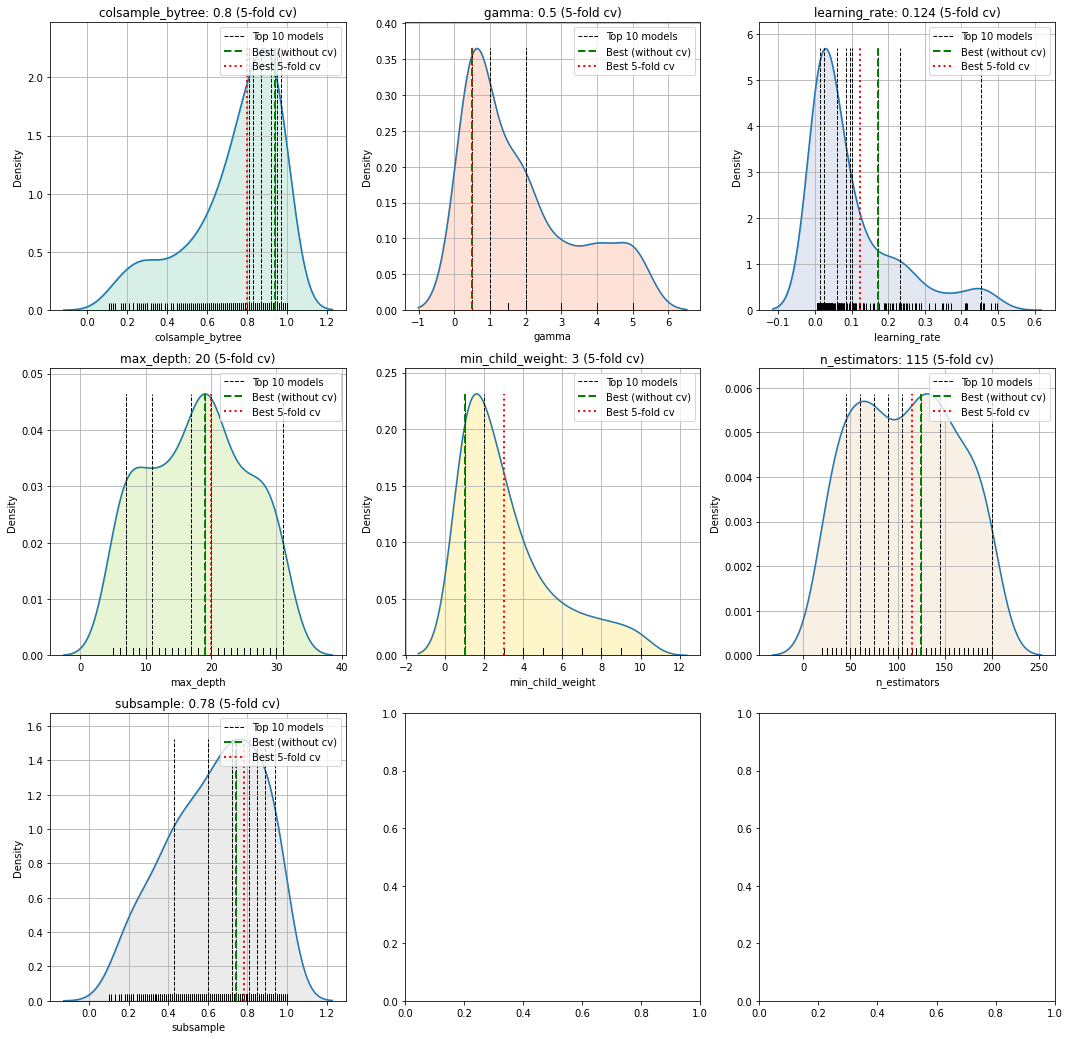

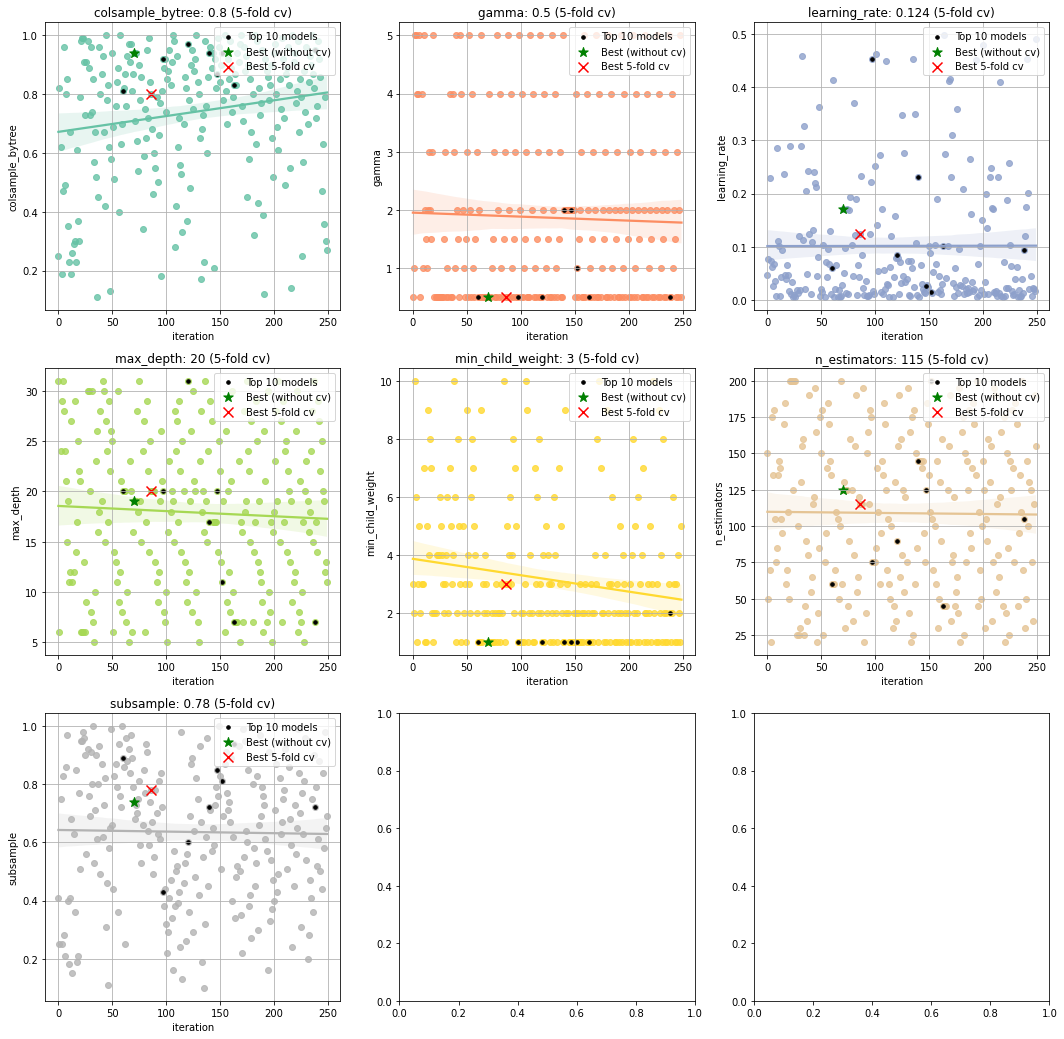

In [12]:
# Plot the hyperparameter tuning.
hgb.plot_params()

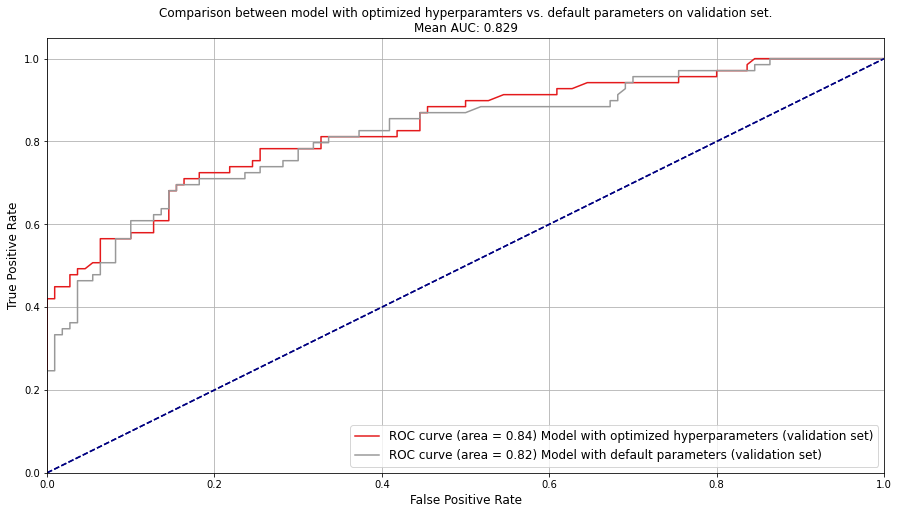

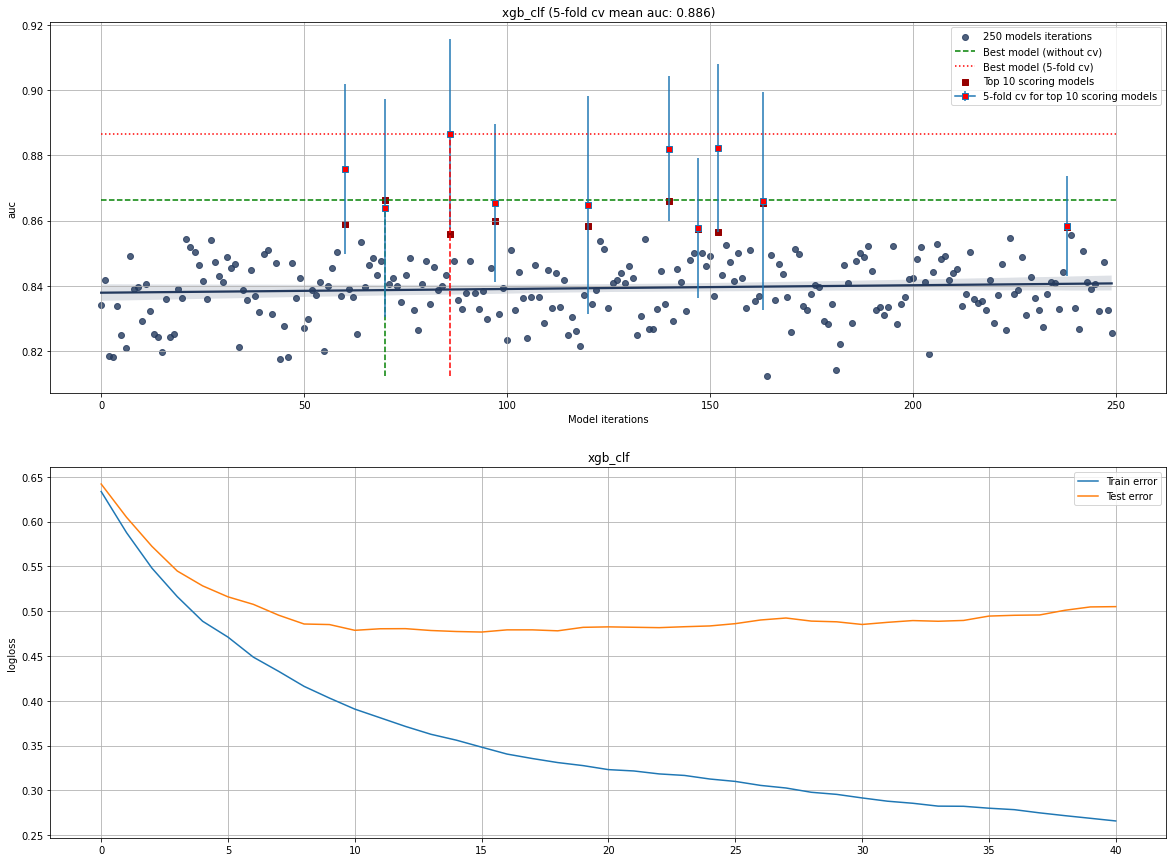

In [13]:
# Plot the summary of all evaluted models.
hgb.plot()

[hgboost] >5-fold crossvalidation is performed with [xgb_clf]


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'5-fold crossvalidation results on best-performing xgb_clf\nMean AUC: 0.984'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

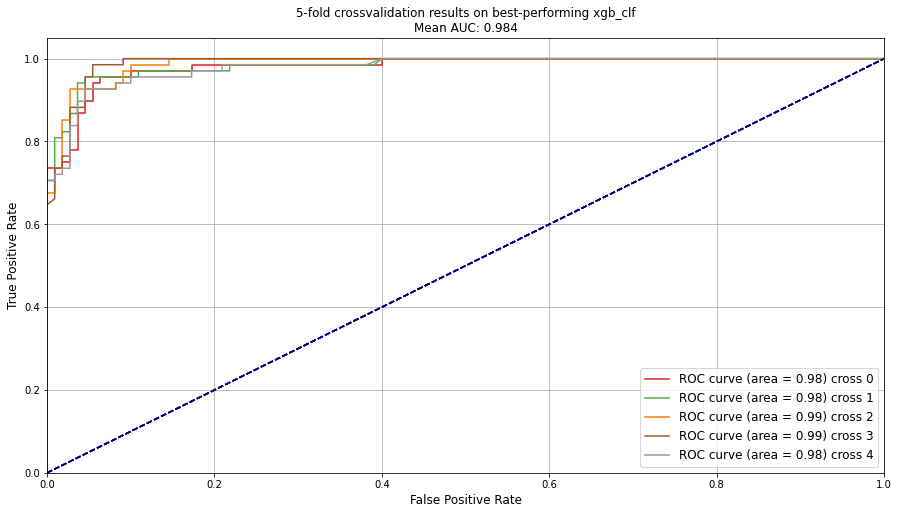

In [14]:
# Plot results on the k-fold cross-validation.
hgb.plot_cv()

[hgboost] >Results are plot from key: "results["val_results"]"


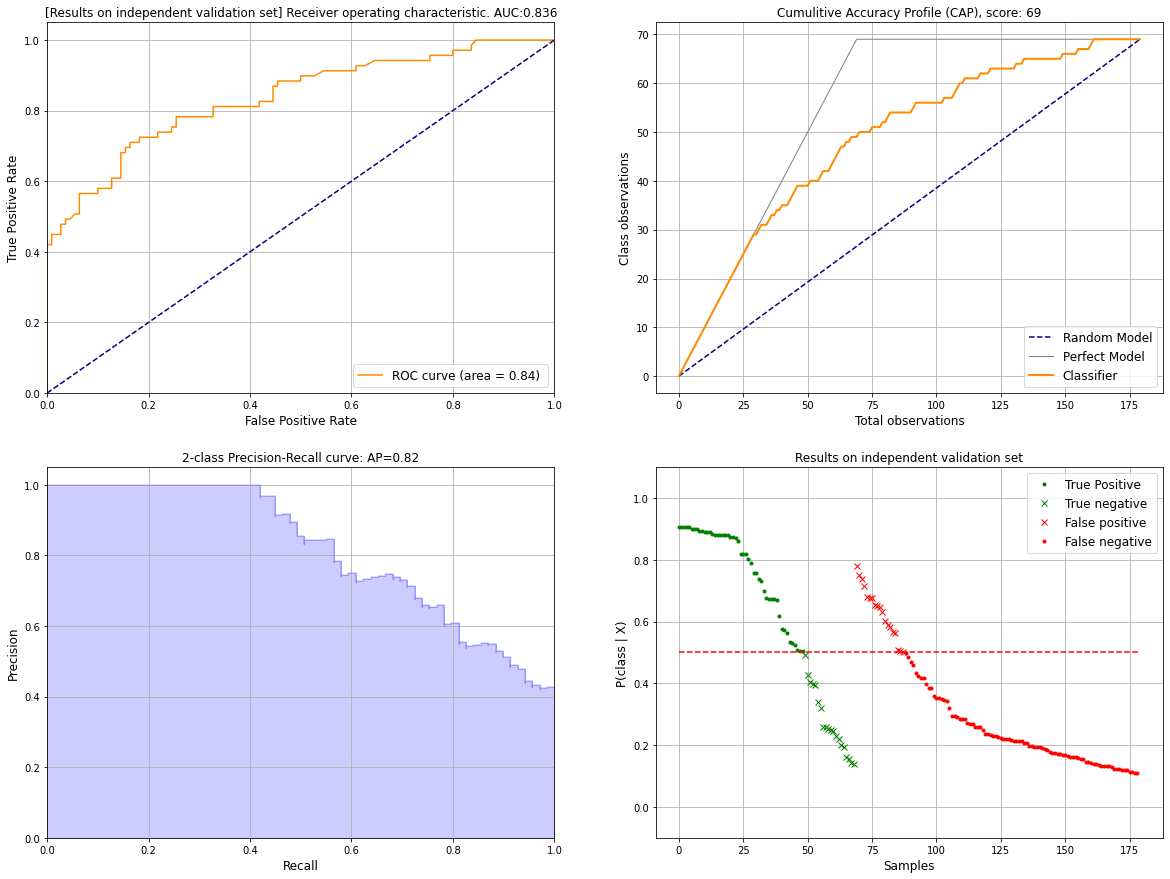

array([[<AxesSubplot:title={'center':'[Results on independent validation set] Receiver operating characteristic. AUC:0.836'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 69'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=0.82'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:title={'center':'Results on independent validation set'}, xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

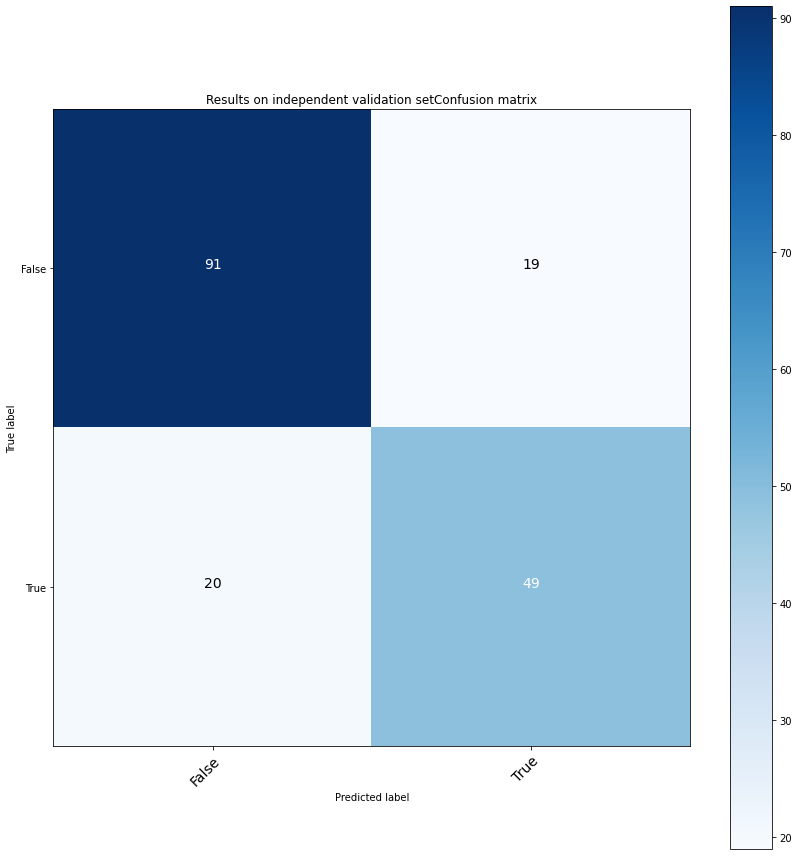

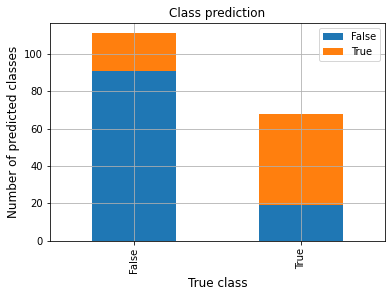

In [15]:
# Plot results on the validation set.
hgb.plot_validation()

[treeplot] >Best detected tree: 114


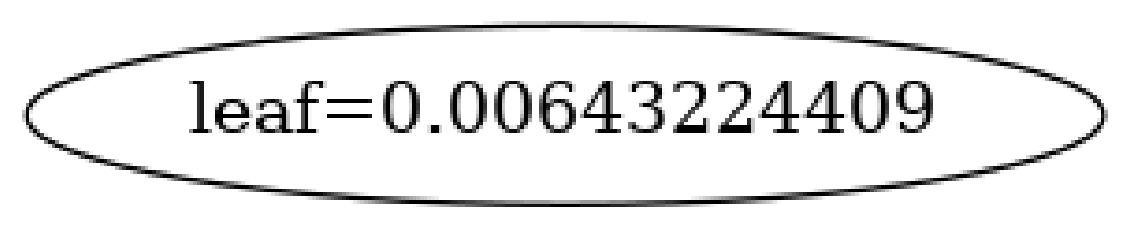

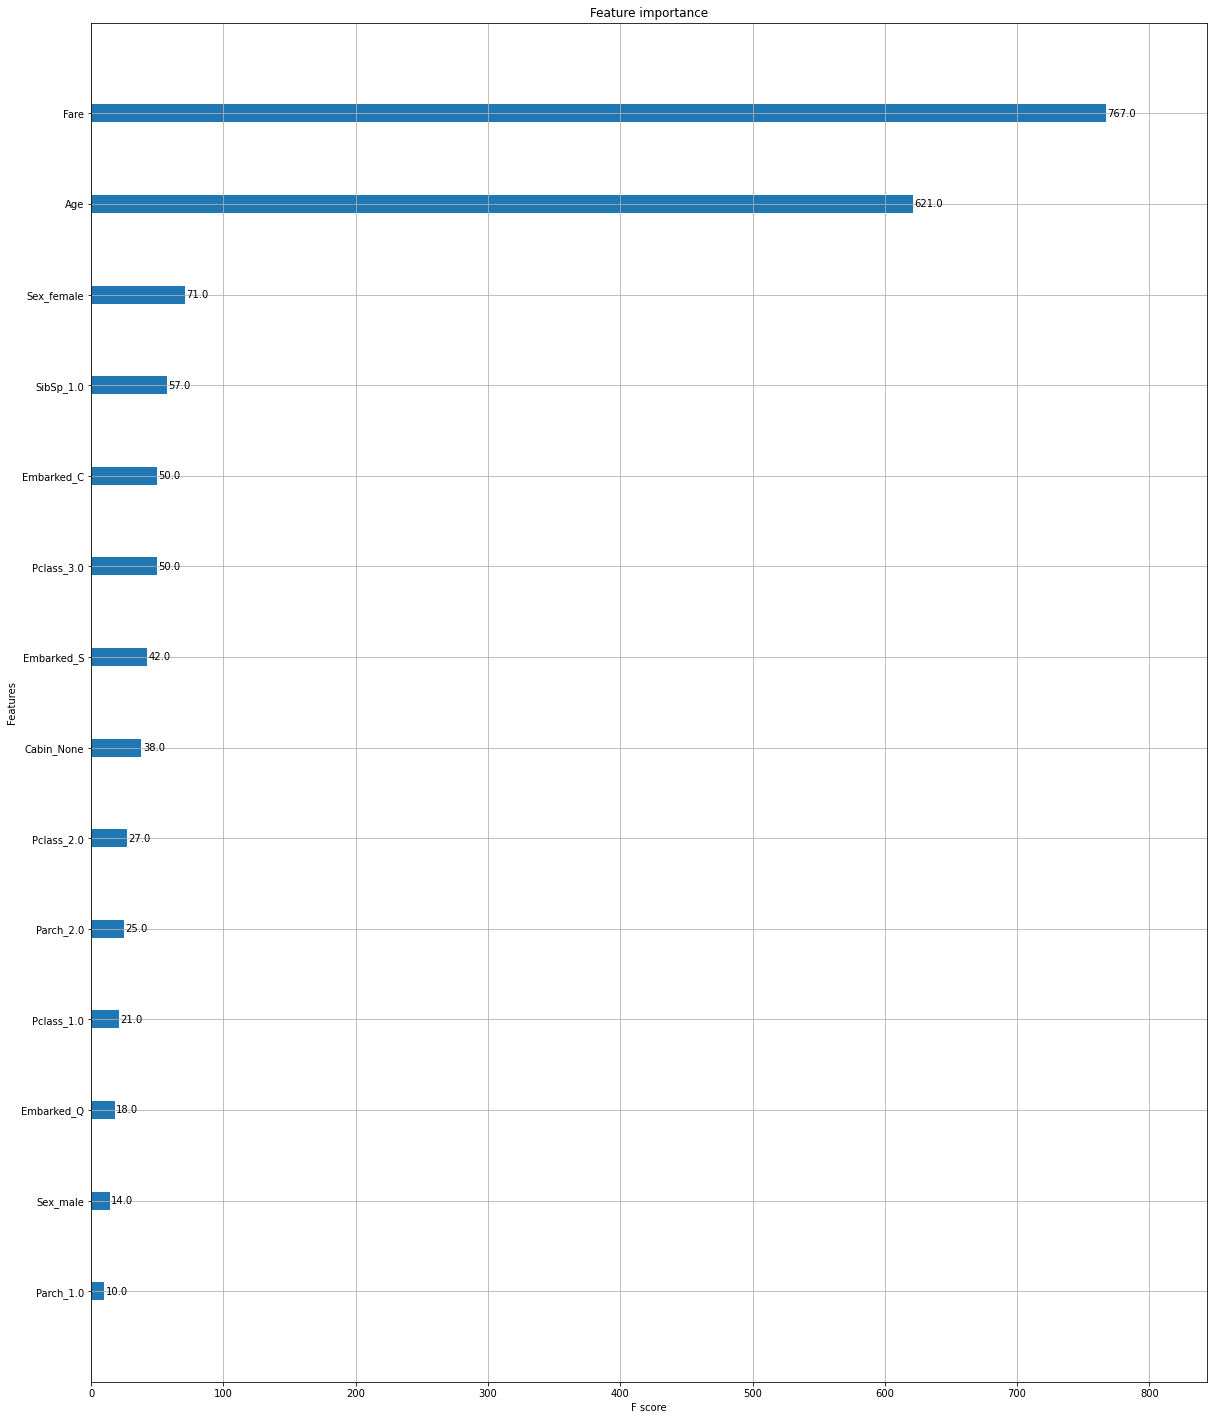

In [16]:
# Plot the best performing tree.
hgb.treeplot()

In [17]:
# Make new prdiction using the model (suppose that X is new and unseen data which is similarly prepared as for the learning process)
y_pred, y_proba = hgb.predict(X)

In [18]:
# Save model
status = hgb.save(filepath='hgboost_model.pkl', overwrite=True)
# [pypickle] Pickle file saved: [hgboost_model.pkl]
# [hgboost] >Saving.. True

# Load model
model = hgb.load(filepath='hgboost_model.pkl')
# [pypickle] Pickle file loaded: [hgboost_model.pkl]
# [hgboost] >Loading succesful!

[pypickle] Pickle file saved: [hgboost_model.pkl]
[hgboost] >Saving.. True
[pypickle] Pickle file loaded: [hgboost_model.pkl]
[hgboost] >Loading succesful!


# 1.2 LightGBM Classifier

In [19]:
# Initialize library.
hgb = hgboost(
    max_eval=250,      # Search space is based  on the number of evaluations.
    threshold=0.5,     # Classification threshold. In case of two-class model this is 0.5.
    cv=5,              # k-folds cross-validation.
    test_size=0.2,     # Percentage split for the testset.
    val_size=0.2,      # Percentage split for the validationset.
    top_cv_evals=10,   # Number of top best performing models that is evaluated.
    is_unbalance=True, # Control the balance of positive and negative weights, useful for unbalanced classes.
    random_state=None, # Fix the random state to create reproducible results.
    n_jobs=-1,         # The number of CPU jobs to run in parallel. -1 means using all processors.
    gpu=False,         # Compute using GPU in case of True.
    verbose=2,         # Print progress to screen.
)

#######################################################
# Import Titanic dataset, and preprocessing
#######################################################
# Import the Titanic dataset
df = hgb.import_example(data='titanic')
y = df['Survived'].values
df.drop(['Survived', 'PassengerId', 'Name'], axis=1, inplace=True)

X = hgb.preprocessing(df)
I = ~np.isnan(y)
X = X.loc[I, :]
y = y[I]

[hgboost] >Import dataset [titanic]


100%|██████████| 9/9 [00:00<00:00, 48.90it/s]


In [20]:
#######################################################
# Classification Search Space
#######################################################

# LightBoost
lgb_clf_params={
    'learning_rate'     : hp.choice('learning_rate', np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'max_depth'         : hp.choice('max_depth', np.arange(5, 75, 1)),
    'boosting_type'     : hp.choice('boosting_type', ['gbdt','goss','dart']),
    'num_leaves'        : hp.choice('num_leaves', np.arange(100, 1000, 100)),
    'n_estimators'      : hp.choice('n_estimators', np.arange(20, 205, 5)),
    'subsample_for_bin' : hp.choice('subsample_for_bin', np.arange(20000, 300000, 20000)),
    'min_child_samples' : hp.choice('min_child_weight', np.arange(20, 500, 5)),
    'reg_alpha'         : hp.quniform('reg_alpha', 0, 1, 0.01),
    'reg_lambda'        : hp.quniform('reg_lambda', 0, 1, 0.01),
    'colsample_bytree'  : hp.quniform('colsample_bytree', 0.6, 1, 0.01),
    'subsample'         : hp.quniform('subsample', 0.5, 1, 100),
    'bagging_fraction'  : hp.choice('bagging_fraction', np.arange(0.2, 1, 0.2)),
    'is_unbalance'      : hp.choice('is_unbalance', [True, False]),
    'early_stopping_rounds' : 25,
}

In [21]:
lgbm_c_results = hgb.lightboost(X, y, pos_label=1, eval_metric='auc')

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fract

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


 10%|█         | 1/10 [00:01<00:10,  1.22s/it]

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001


 30%|███       | 3/10 [00:03<00:07,  1.14s/it]

[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001


 40%|████      | 4/10 [00:04<00:05,  1.01it/s]

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


 50%|█████     | 5/10 [00:05<00:05,  1.08s/it]

[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001


 60%|██████    | 6/10 [00:06<00:03,  1.04it/s]

[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2


 70%|███████   | 7/10 [00:06<00:02,  1.23it/s]

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001


 80%|████████  | 8/10 [00:07<00:01,  1.37it/s]

[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=0.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


 90%|█████████ | 9/10 [00:07<00:00,  1.60it/s]

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


In [22]:
print(lgbm_c_results.keys())

dict_keys(['params', 'summary', 'trials', 'model', 'val_results', 'comparison_results'])


In [23]:
print(lgbm_c_results['params'])

{'bagging_fraction': 0.4, 'boosting_type': 'dart', 'colsample_bytree': 0.66, 'is_unbalance': True, 'learning_rate': 0.44352484448272034, 'max_depth': 57, 'min_child_weight': 0.001, 'n_estimators': 140, 'num_leaves': 900, 'reg_alpha': 0.33, 'reg_lambda': 0.38, 'subsample': 0.0, 'subsample_for_bin': 20000}


In [24]:
lgbm_c_results['summary']

,bagging_fraction,boosting_type,colsample_bytree,device,gpu_device_id,gpu_platform_id,is_unbalance,learning_rate,max_depth,min_child_samples,min_child_weight,n_estimators,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin,loss,eval_time,status,tid,best,loss_mean,loss_std,best_cv,loss_validation,default_params
0,0.4,goss,0.72,cpu,0,0,True,0.265886,12,140,0.001,165,100,0.05,0.1,0.0,100000,0.851738,1.665496e+09,ok,0.0,0.0,NaN,NaN,0.0,NaN,False
1,0.8,goss,0.68,cpu,0,0,True,0.040727,28,115,0.001,160,700,0.1,0.21,0.0,260000,0.852473,1.665496e+09,ok,1.0,0.0,NaN,NaN,0.0,NaN,False
2,0.8,goss,0.67,cpu,0,0,True,0.046338,57,60,0.001,25,900,0.05,0.2,0.0,280000,0.867781,1.665496e+09,ok,2.0,0.0,NaN,NaN,0.0,NaN,False
3,0.8,goss,0.72,cpu,0,0,True,0.025332,62,330,0.001,40,500,0.81,0.01,0.0,60000,0.500000,1.665496e+09,ok,3.0,0.0,NaN,NaN,0.0,NaN,False
4,0.8,goss,0.82,cpu,0,0,True,0.322686,58,375,0.001,90,300,0.42,0.51,0.0,120000,0.500000,1.665496e+09,ok,4.0,0.0,NaN,NaN,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.4,goss,0.84,cpu,0,0,True,0.008574,61,220,0.001,155,500,0.39,0.84,0.0,140000,0.647193,1.665496e+09,ok,246.0,0.0,NaN,NaN,0.0,NaN,False
247,0.6,dart,0.92,cpu,0,0,True,0.060263,17,170,0.001,35,300,0.64,0.3,0.0,120000,0.847326,1.665496e+09,ok,247.0,0.0,NaN,NaN,0.0,NaN,False
248,0.4,dart,0.74,cpu,0,0,True,0.443525,33,150,0.001,150,100,0.43,0.33,0.0,180000,0.859626,1.665496e+09,ok,248.0,0.0,NaN,NaN,0.0,NaN,False
249,0.8,dart,0.87,cpu,0,0,True,0.130132,5,390,0.001,30,900,0.82,0.5,0.0,20000,0.500000,1.665496e+09,ok,249.0,0.0,NaN,NaN,0.0,NaN,False


In [25]:
lgbm_c_results['trials']

[colourmap]> Warning: Colormap [Set2] can not create [13] unique colors! Available unique colors: [8].


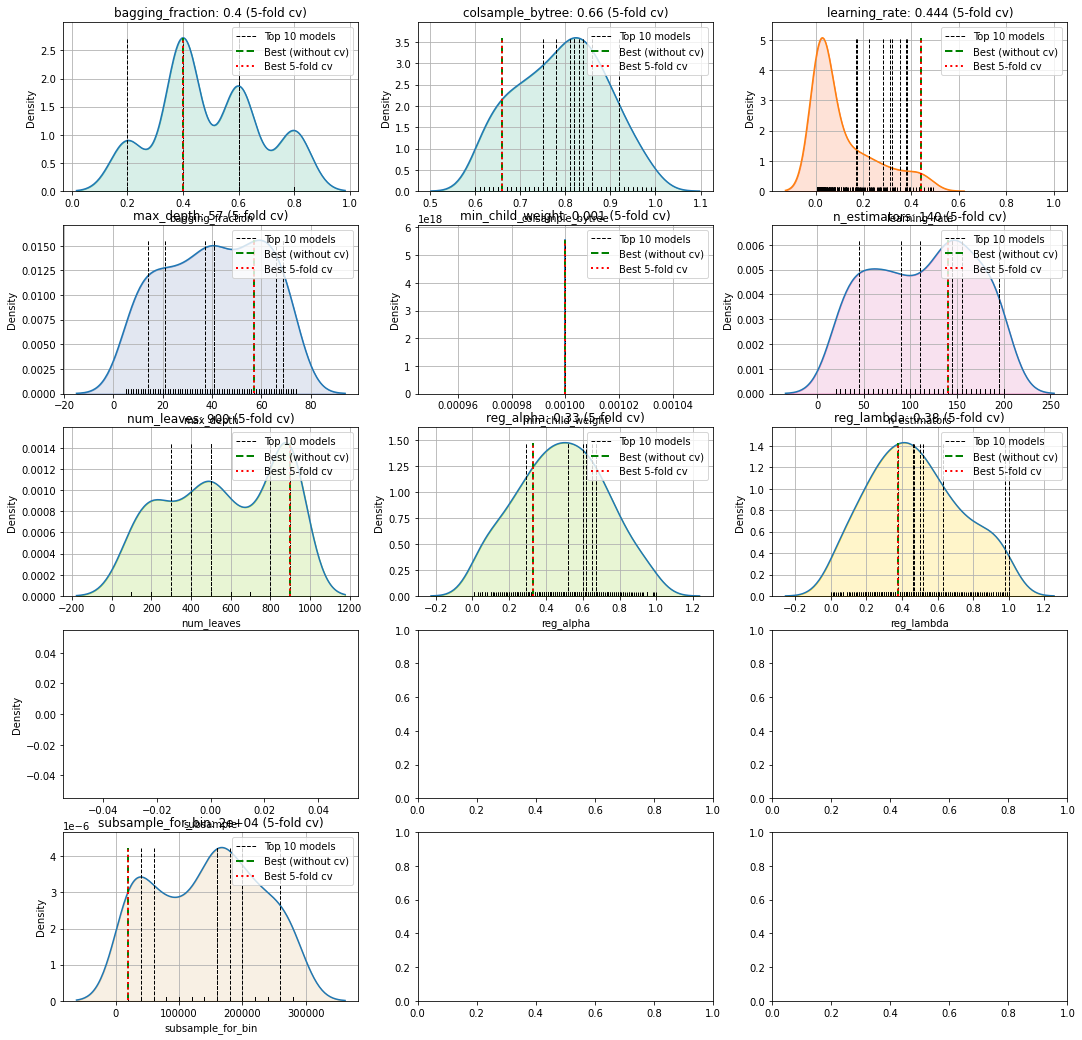

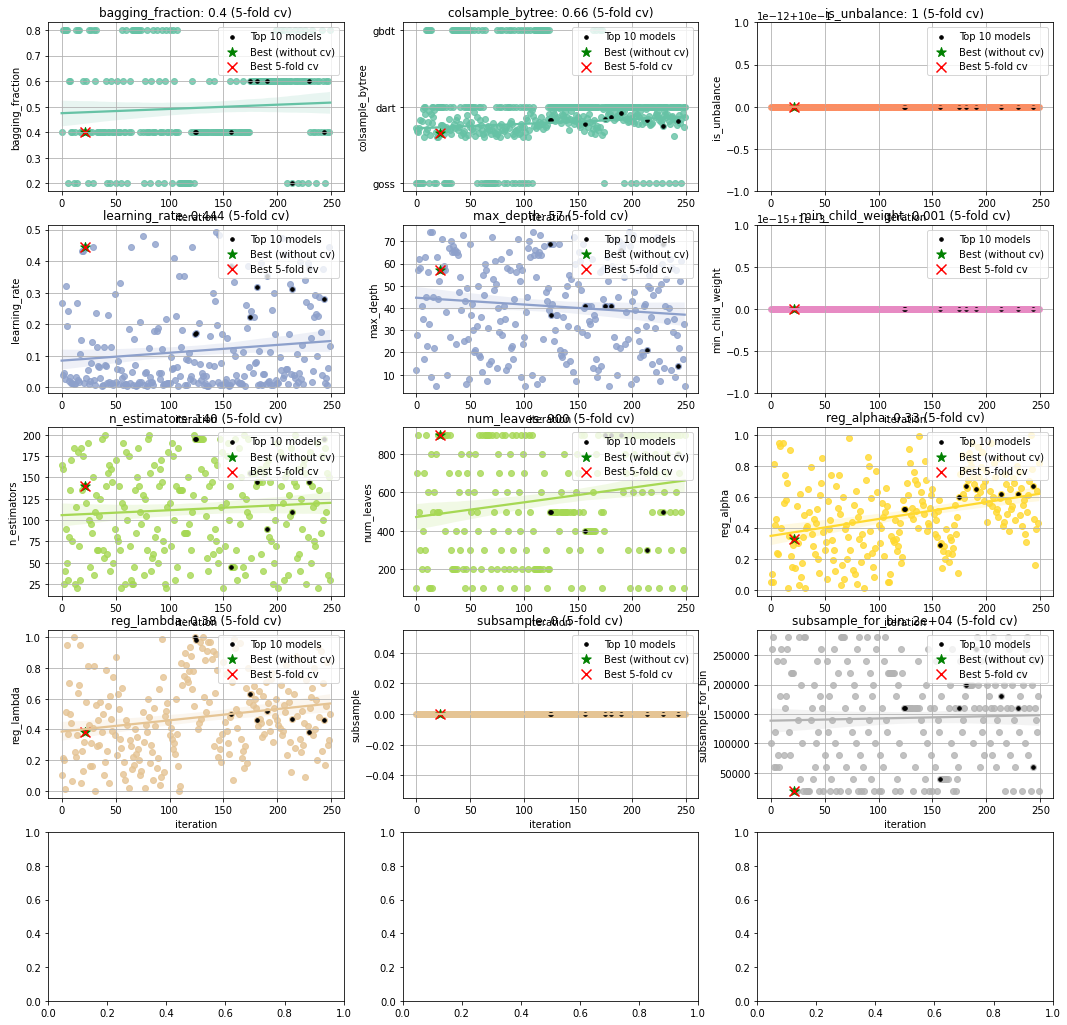

In [26]:
hgb.plot_params()

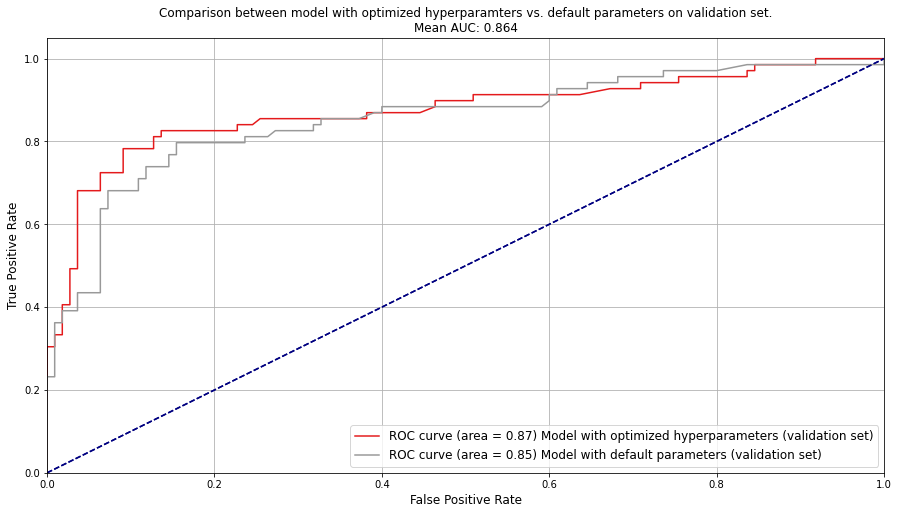

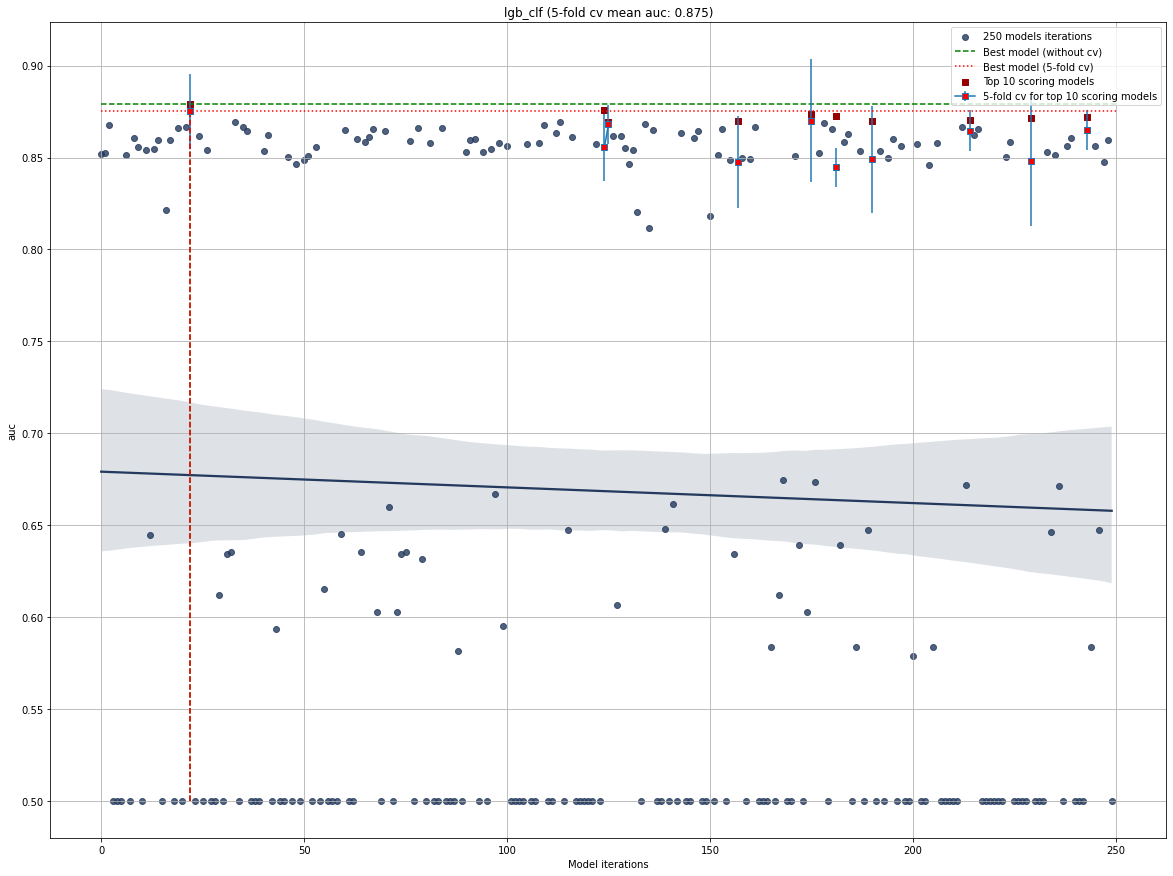

In [27]:
hgb.plot()

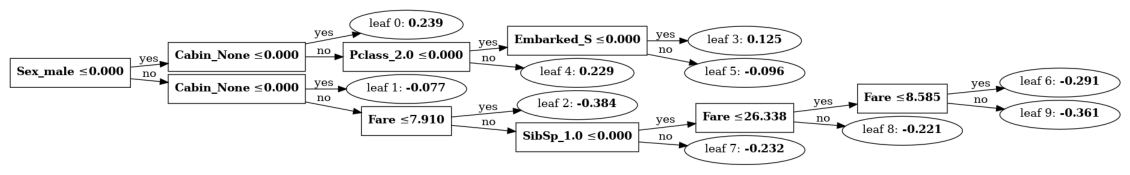

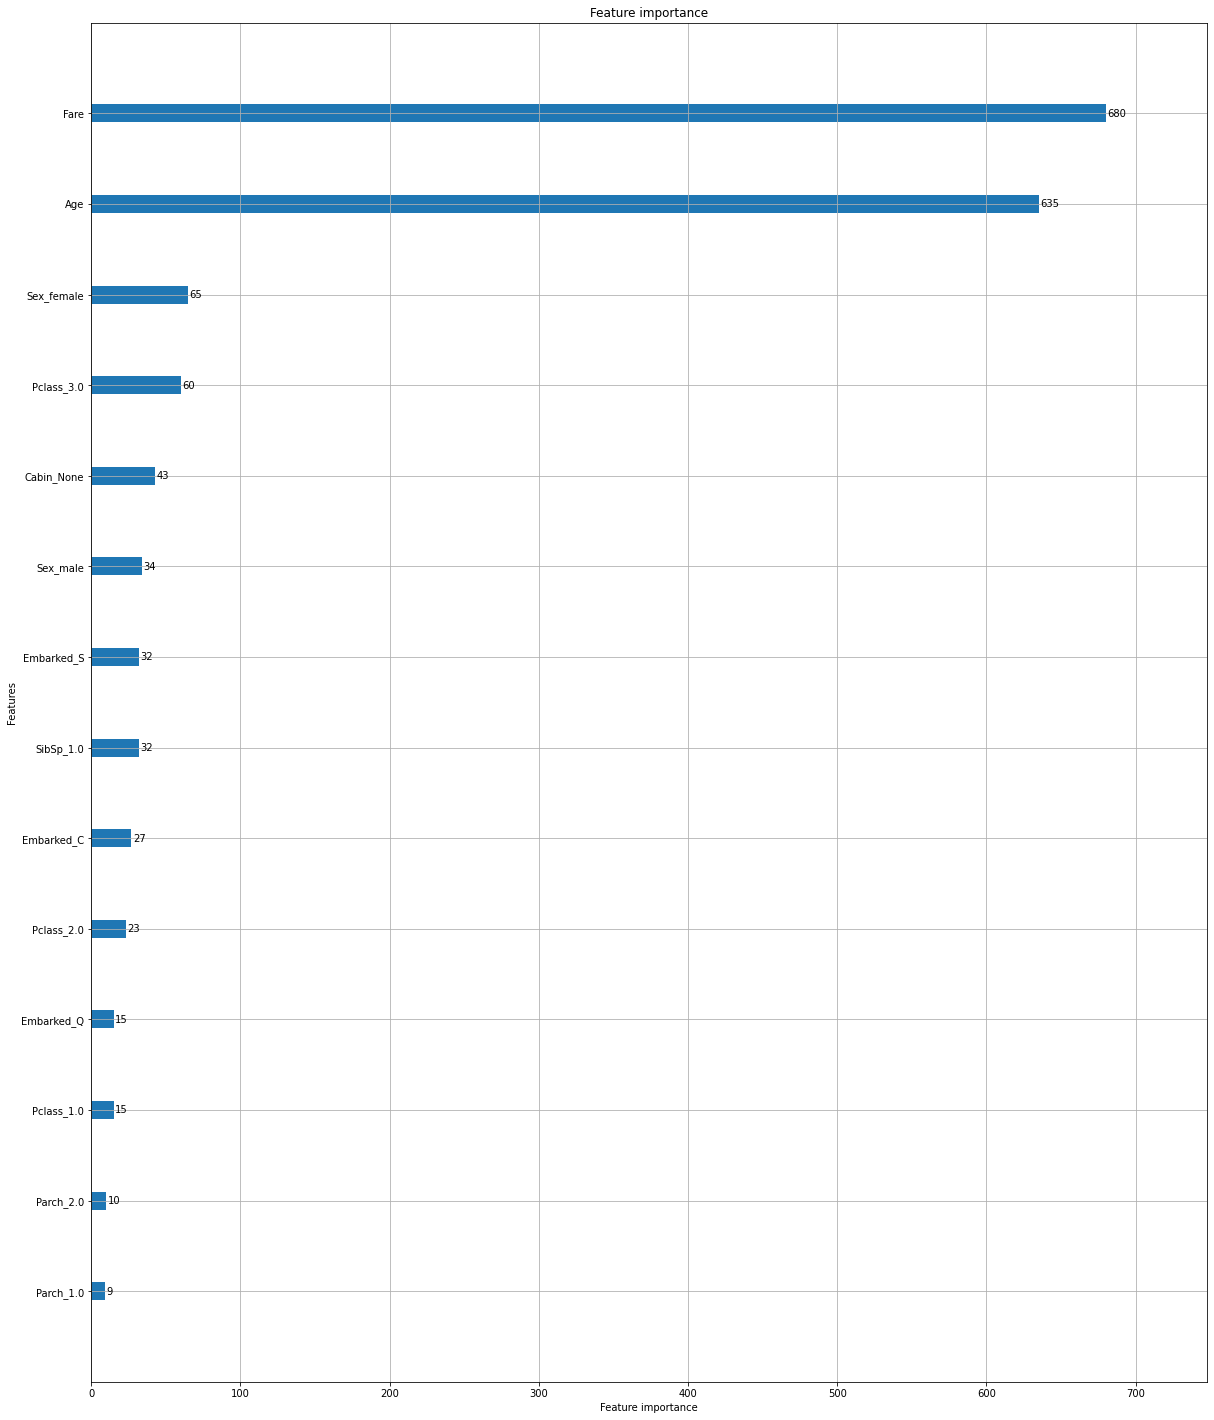

In [28]:
# Plot the best performing tree.
hgb.treeplot()

[hgboost] >5-fold crossvalidation is performed with [lgb_clf]


100%|██████████| 5/5 [00:00<00:00, 31.52it/s]


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'5-fold crossvalidation results on best-performing lgb_clf\nMean AUC: 0.968'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

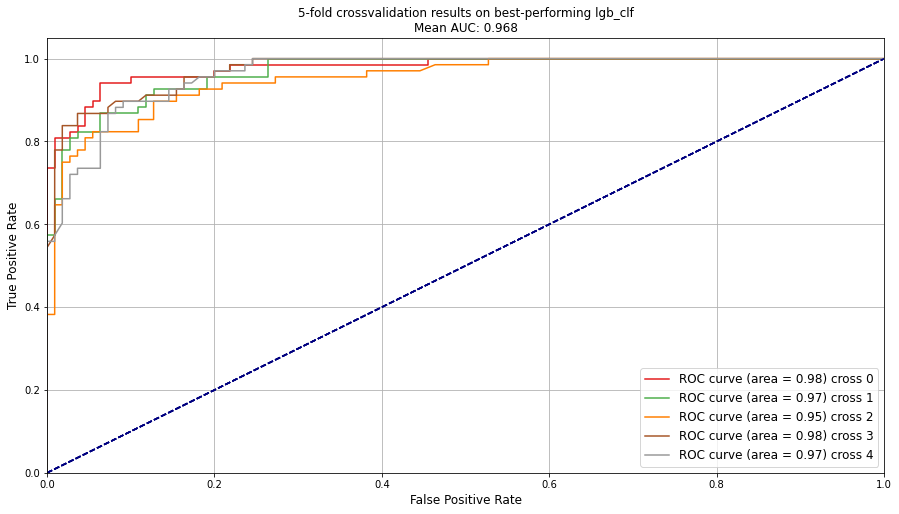

In [29]:
hgb.plot_cv()

[hgboost] >Results are plot from key: "results["val_results"]"


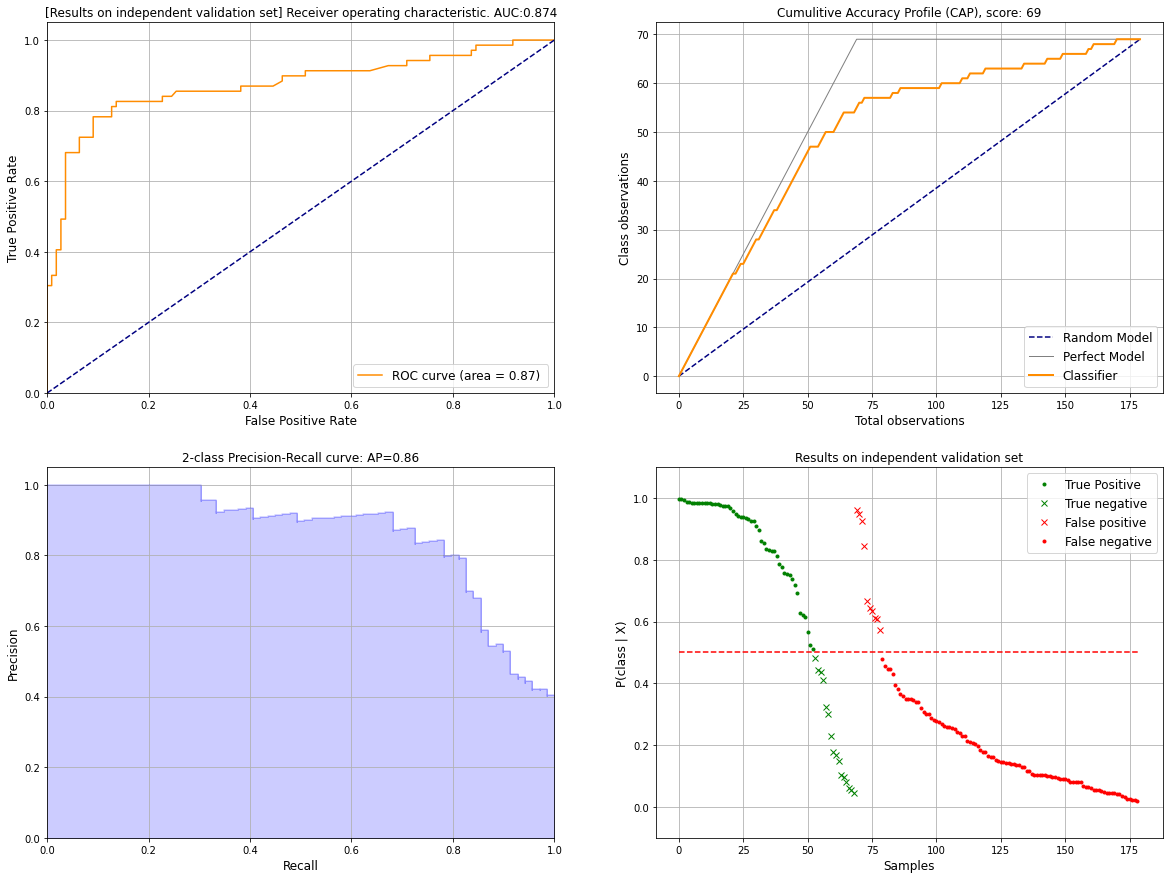

array([[<AxesSubplot:title={'center':'[Results on independent validation set] Receiver operating characteristic. AUC:0.874'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 69'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=0.86'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:title={'center':'Results on independent validation set'}, xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

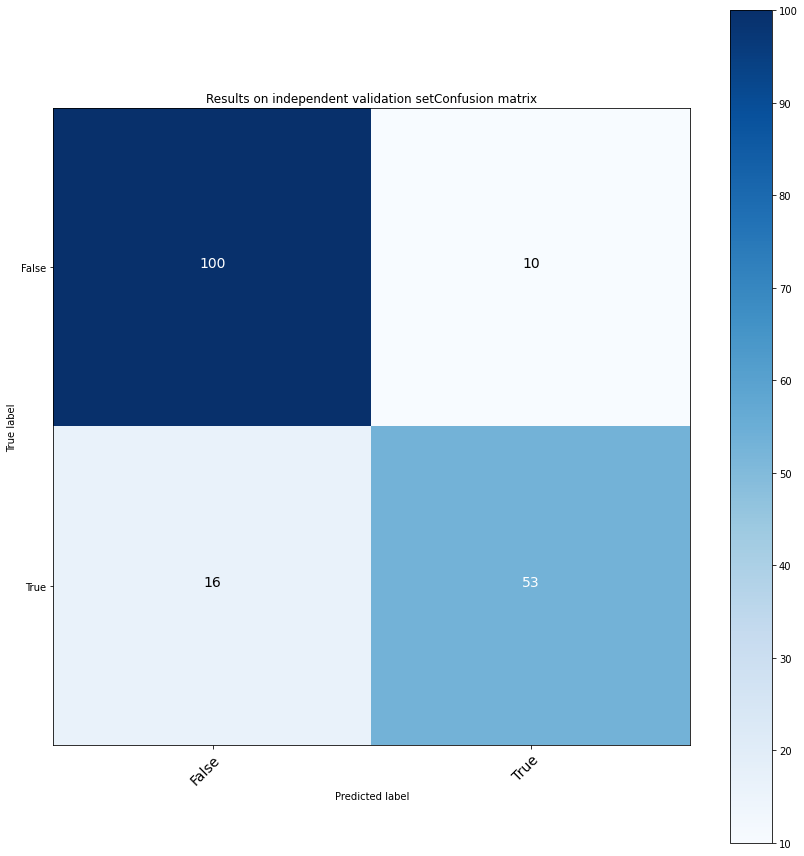

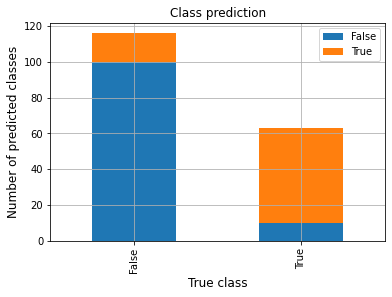

In [30]:
# Plot results on the validation set.
hgb.plot_validation()

In [31]:
# Make new prdiction using the model (suppose that X is new and unseen data which is similarly prepared as for the learning process)
y_pred, y_proba = hgb.predict(X)

# 1.3 Catboost Classifier

In [32]:
# Initialize library.
hgb = hgboost(
    max_eval=250,      # Search space is based  on the number of evaluations.
    threshold=0.5,     # Classification threshold. In case of two-class model this is 0.5.
    cv=5,              # k-folds cross-validation.
    test_size=0.2,     # Percentage split for the testset.
    val_size=0.2,      # Percentage split for the validationset.
    top_cv_evals=10,   # Number of top best performing models that is evaluated.
    is_unbalance=True, # Control the balance of positive and negative weights, useful for unbalanced classes.
    random_state=None, # Fix the random state to create reproducible results.
    n_jobs=-1,         # The number of CPU jobs to run in parallel. -1 means using all processors.
    gpu=False,         # Compute using GPU in case of True.
    verbose=2,         # Print progress to screen.
)

#######################################################
# Import Titanic dataset, and preprocessing
#######################################################
# Import the Titanic dataset
df = hgb.import_example(data='titanic')
y = df['Survived'].values
df.drop(['Survived', 'PassengerId', 'Name'], axis=1, inplace=True)

X = hgb.preprocessing(df)
I = ~np.isnan(y)
X = X.loc[I, :]
y = y[I]

[hgboost] >Import dataset [titanic]


100%|██████████| 9/9 [00:00<00:00, 48.76it/s]


In [33]:
#######################################################
# Classification Search Space
#######################################################
# CatBoost
ctb_clf_params={
    'learning_rate': hp.choice('learning_rate', np.logspace(np.log10(0.005), np.log10(0.31), base=10, num=1000)),
    'depth': hp.choice('max_depth', np.arange(2, 16, 1, dtype=int)),
    'iterations': hp.choice('iterations', np.arange(100, 1000, 100)),
    'l2_leaf_reg': hp.choice('l2_leaf_reg', np.arange(1, 100, 2)),
    'border_count': hp.choice('border_count', np.arange(5, 200, 1)),
    #'scale_pos_weight': scale_pos_weight,
}

In [34]:
cb_c_results = hgb.catboost(X, y, pos_label=1, eval_metric='auc')

100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


0:	learn: 0.6737805	total: 1.11ms	remaining: 552ms
1:	learn: 0.6591611	total: 2.35ms	remaining: 585ms
2:	learn: 0.6466286	total: 3.31ms	remaining: 548ms
3:	learn: 0.6374047	total: 4.23ms	remaining: 525ms
4:	learn: 0.6229617	total: 5.18ms	remaining: 513ms
5:	learn: 0.6102485	total: 5.82ms	remaining: 480ms
6:	learn: 0.6003306	total: 6.45ms	remaining: 454ms
7:	learn: 0.5897030	total: 7.07ms	remaining: 435ms
8:	learn: 0.5779484	total: 7.66ms	remaining: 418ms
9:	learn: 0.5695693	total: 8.27ms	remaining: 405ms
10:	learn: 0.5614942	total: 8.88ms	remaining: 395ms
11:	learn: 0.5540042	total: 9.5ms	remaining: 386ms
12:	learn: 0.5487457	total: 10.2ms	remaining: 381ms
13:	learn: 0.5412995	total: 10.8ms	remaining: 375ms
14:	learn: 0.5355634	total: 11.4ms	remaining: 368ms
15:	learn: 0.5323657	total: 12ms	remaining: 362ms
16:	learn: 0.5279657	total: 12.6ms	remaining: 358ms
17:	learn: 0.5228412	total: 13.2ms	remaining: 353ms
18:	learn: 0.5203995	total: 13.7ms	remaining: 346ms
19:	learn: 0.5169820	tota

In [35]:
print(cb_c_results.keys())

dict_keys(['params', 'summary', 'trials', 'model', 'val_results', 'comparison_results'])


In [36]:
print(cb_c_results['params'])

{'border_count': 13, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.03248899057507515, 'max_depth': None}


In [37]:
cb_c_results['summary']

,border_count,depth,devices,iterations,l2_leaf_reg,learning_rate,max_depth,scale_pos_weight,task_type,thread_count,loss,eval_time,status,tid,best,loss_mean,loss_std,best_cv,loss_validation,default_params
0,183,5,None,800,71,0.007016,None,None,CPU,None,0.861230,1.665496e+09,ok,0.0,0.0,NaN,NaN,0.0,NaN,False
1,6,11,None,800,23,0.052248,None,None,CPU,None,0.864505,1.665496e+09,ok,1.0,0.0,NaN,NaN,0.0,NaN,False
2,122,12,None,600,1,0.012719,None,None,CPU,None,0.860829,1.665496e+09,ok,2.0,0.0,NaN,NaN,0.0,NaN,False
3,71,8,None,300,21,0.011566,None,None,CPU,None,0.865508,1.665496e+09,ok,3.0,0.0,NaN,NaN,0.0,NaN,False
4,98,2,None,800,7,0.005476,None,None,CPU,None,0.861698,1.665496e+09,ok,4.0,0.0,NaN,NaN,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,153,4,None,100,57,0.006147,None,None,CPU,None,0.855816,1.665497e+09,ok,246.0,0.0,NaN,NaN,0.0,NaN,False
247,38,13,None,400,39,0.107215,None,None,CPU,None,0.865040,1.665497e+09,ok,247.0,0.0,NaN,NaN,0.0,NaN,False
248,118,4,None,900,43,0.014517,None,None,CPU,None,0.863770,1.665497e+09,ok,248.0,0.0,NaN,NaN,0.0,NaN,False
249,92,9,None,500,97,0.014279,None,None,CPU,None,0.861096,1.665497e+09,ok,249.0,0.0,NaN,NaN,0.0,NaN,False


In [38]:
cb_c_results['trials']

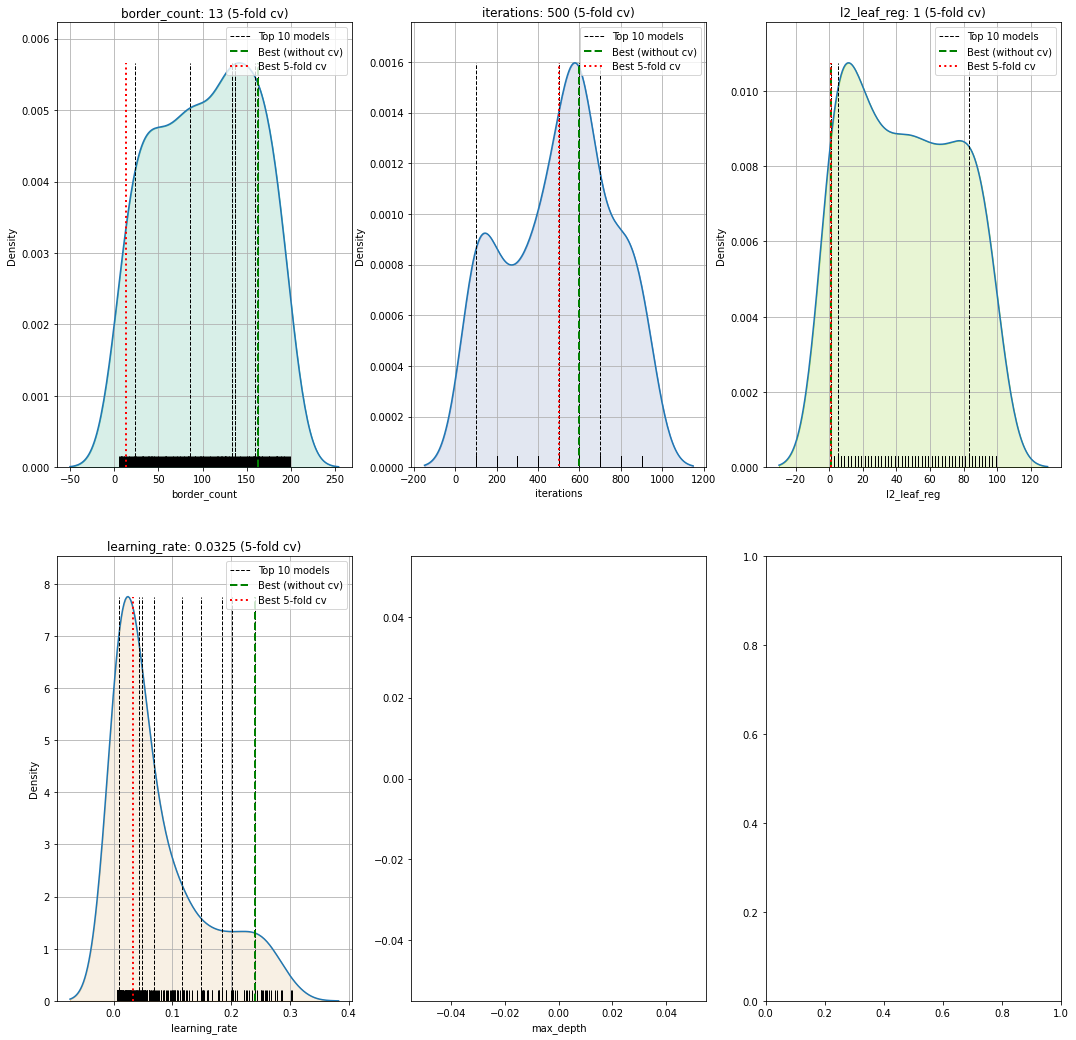

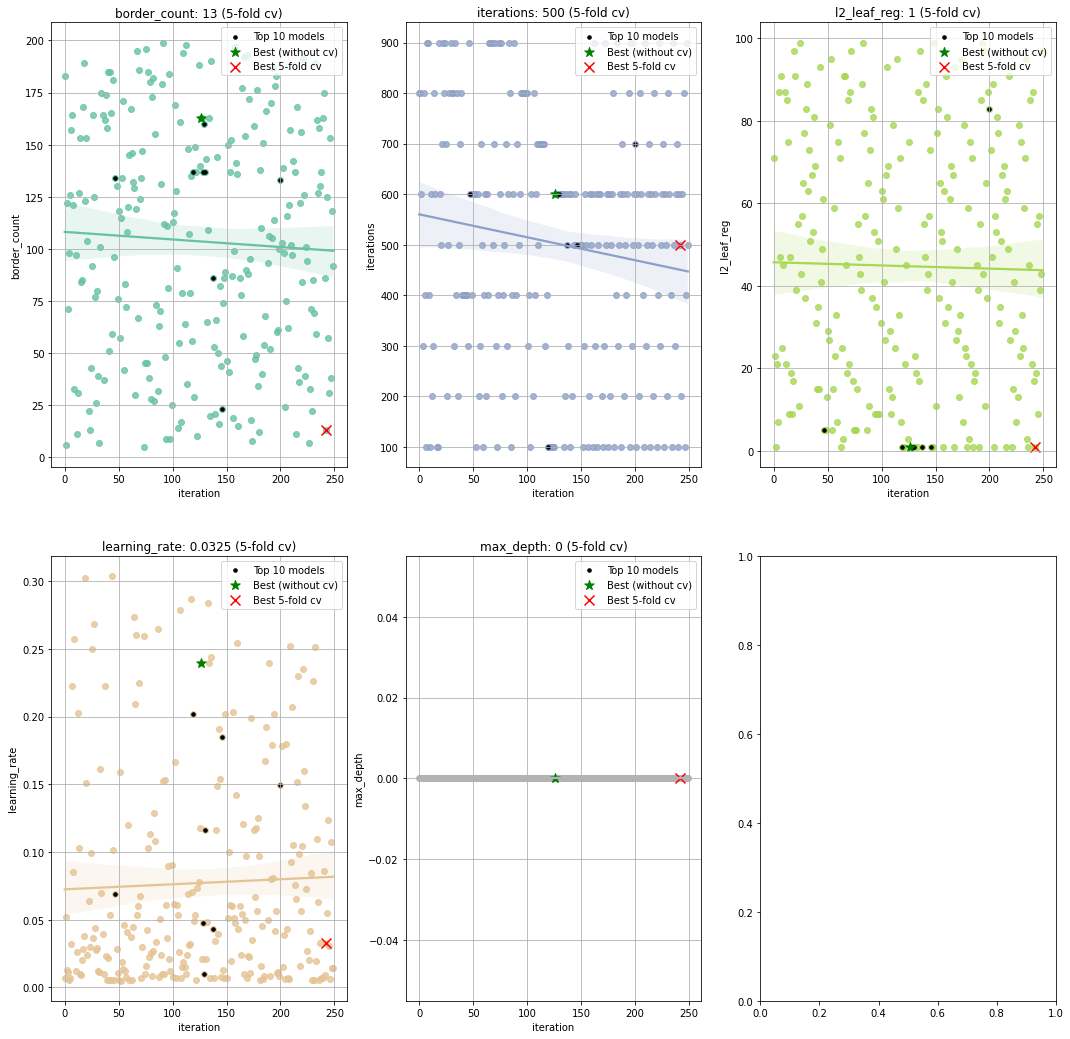

In [39]:
hgb.plot_params()

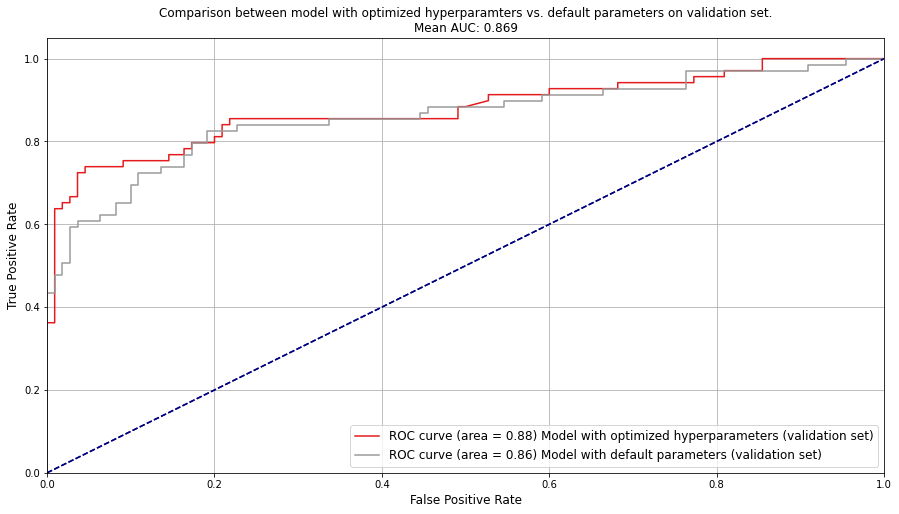

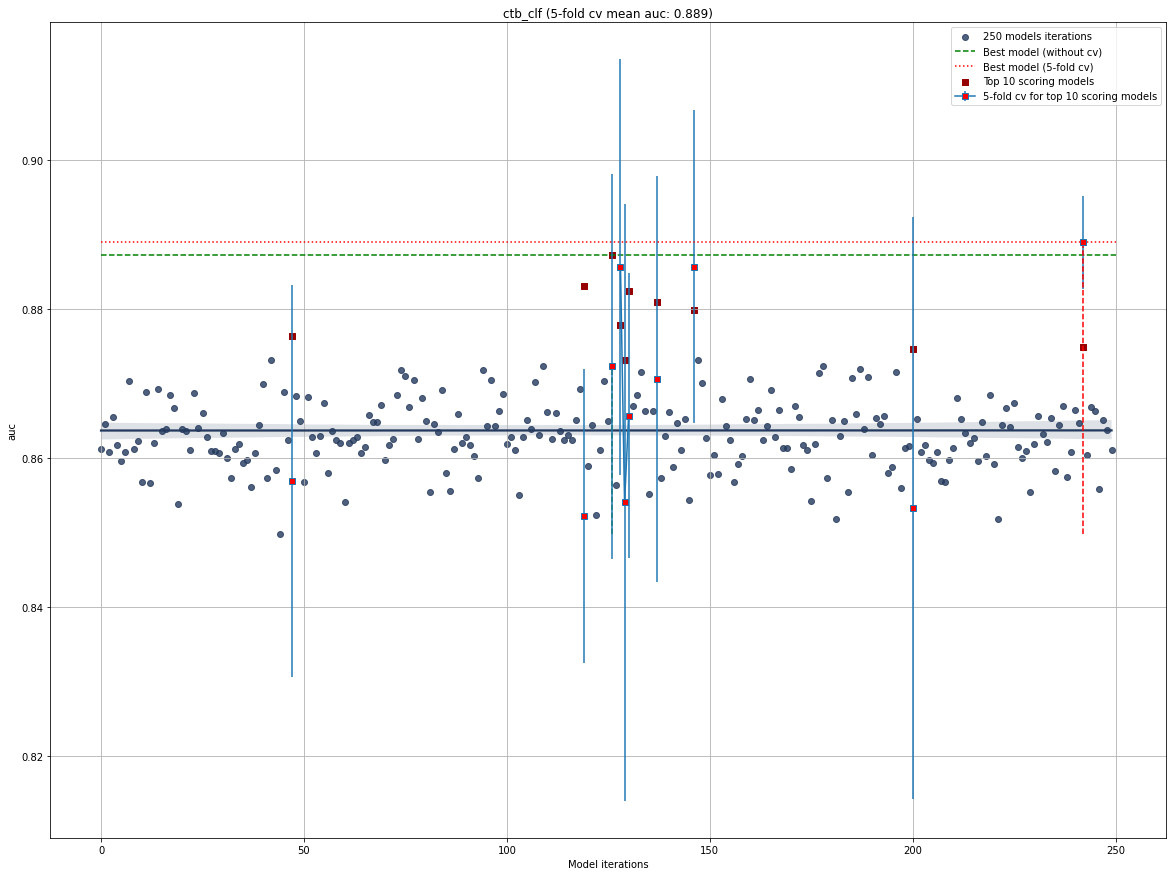

In [40]:
hgb.plot()

In [41]:
# Plot the best performing tree.
hgb.treeplot()

[treeplot] >Model not recognized: <catboost.core.catboostclassif


[hgboost] >5-fold crossvalidation is performed with [ctb_clf]


100%|██████████| 5/5 [00:00<00:00, 16.82it/s]


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'5-fold crossvalidation results on best-performing ctb_clf\nMean AUC: 0.942'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

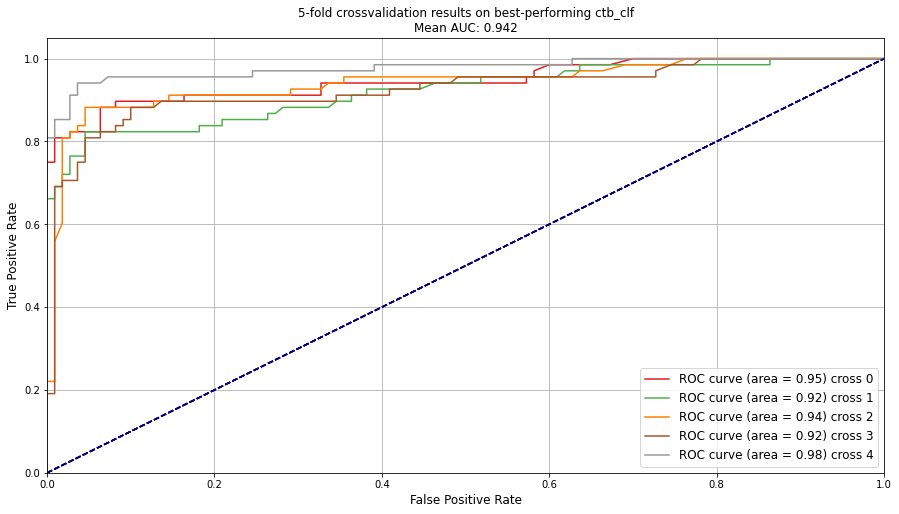

In [42]:
hgb.plot_cv()

[hgboost] >Results are plot from key: "results["val_results"]"


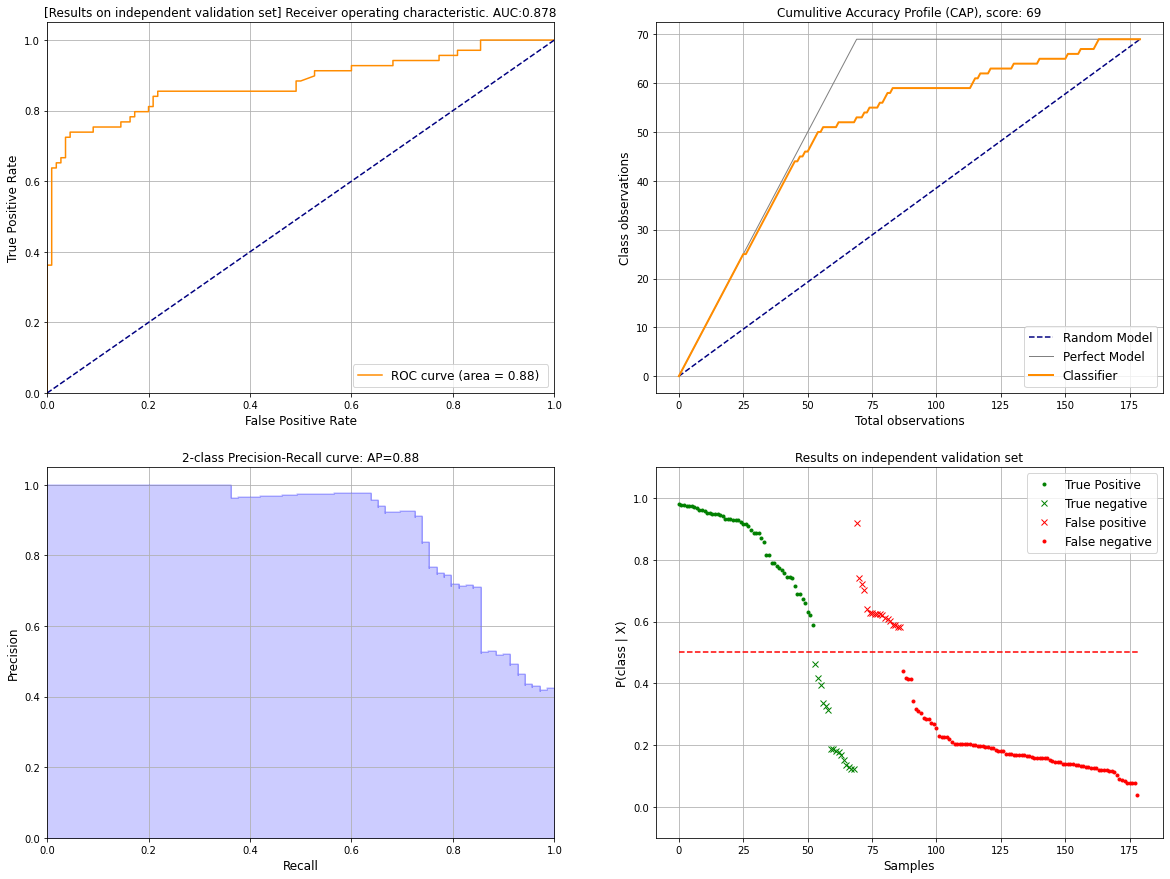

array([[<AxesSubplot:title={'center':'[Results on independent validation set] Receiver operating characteristic. AUC:0.878'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 69'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=0.88'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:title={'center':'Results on independent validation set'}, xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

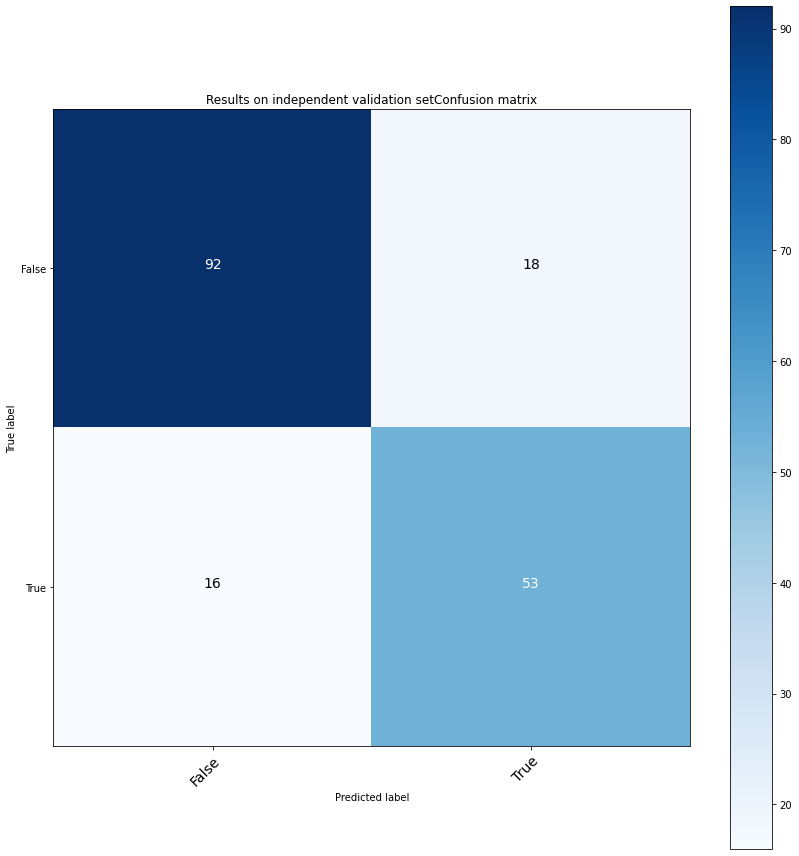

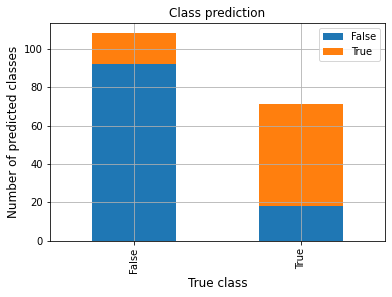

In [43]:
# Plot results on the validation set.
hgb.plot_validation()

In [44]:
# Make new prdiction using the model (suppose that X is new and unseen data which is similarly prepared as for the learning process)
y_pred, y_proba = hgb.predict(X)

# 1.4 Ensemble Models

In [45]:
###########################################################################
# Fit ensemble model for classification task.
hgb.ensemble(X, y, pos_label=1, methods=['xgb_clf', 'ctb_clf', 'lgb_clf'])

100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


0:	learn: 0.6335092	total: 949us	remaining: 663ms
1:	learn: 0.6010132	total: 2.13ms	remaining: 744ms
2:	learn: 0.5714867	total: 2.86ms	remaining: 665ms
3:	learn: 0.5438618	total: 3.67ms	remaining: 639ms
4:	learn: 0.5312269	total: 4.38ms	remaining: 609ms
5:	learn: 0.5171482	total: 5.07ms	remaining: 587ms
6:	learn: 0.5042474	total: 5.9ms	remaining: 584ms
7:	learn: 0.4965066	total: 6.66ms	remaining: 576ms
8:	learn: 0.4918797	total: 7.44ms	remaining: 571ms
9:	learn: 0.4869702	total: 8.15ms	remaining: 562ms
10:	learn: 0.4839440	total: 8.8ms	remaining: 551ms
11:	learn: 0.4821772	total: 9.49ms	remaining: 544ms
12:	learn: 0.4799700	total: 10.1ms	remaining: 536ms
13:	learn: 0.4770244	total: 10.9ms	remaining: 536ms
14:	learn: 0.4717893	total: 11.6ms	remaining: 532ms
15:	learn: 0.4690775	total: 12.4ms	remaining: 531ms
16:	learn: 0.4661228	total: 13.1ms	remaining: 528ms
17:	learn: 0.4617804	total: 14ms	remaining: 529ms
18:	learn: 0.4614633	total: 14.7ms	remaining: 528ms
19:	learn: 0.4603166	total:

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8


 10%|█         | 1/10 [00:00<00:03,  2.28it/s]

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2


 20%|██        | 2/10 [00:00<00:03,  2.30it/s]

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2


 30%|███       | 3/10 [00:01<00:02,  2.34it/s]

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2


 40%|████      | 4/10 [00:01<00:02,  2.44it/s]

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8


 50%|█████     | 5/10 [00:02<00:01,  2.59it/s]

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.0 will be ignored. Current value: bagging_fraction=0.4


 60%|██████    | 6/10 [00:02<00:01,  2.47it/s]

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8


 70%|███████   | 7/10 [00:02<00:01,  2.60it/s]

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2


 80%|████████  | 8/10 [00:03<00:00,  2.34it/s]

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8


 90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.0 will be ignored. Current value: bagging_fraction=0.2


100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
0:	learn: 0.6452160	total: 47.7ms	remaining: 33.4s
1:	learn: 0.6079237	total: 48.6ms	remaining: 17s
2:	learn: 0.5727993	total: 49.4ms	remaining: 11.5s
3:	learn: 0.5579448	total: 50.1ms	remaining: 8.72s
4:	learn: 0.5407711	total: 51ms	remaining: 7.09s
5:	learn: 0.5264269	total: 51.8ms	remaining: 6s
6:	learn: 0.5153952	total: 52.6ms	remaining: 5.21s
7:	learn: 0.5021894	total: 53.5ms	remaining: 4.63s
8:	learn: 0.4950928	total: 54.3ms	remaining: 4.17s
9:	learn: 0.4891859	total: 54.9ms	remaining: 3.79s
10:	learn: 0.4845649	total: 55.4ms	remaining: 3.47s
11:	learn: 0.4772111	total: 56ms	remaining: 3.21s
12:	learn: 0.4737877	total: 56.5ms	remaining: 2.98s
13:	learn: 0.4714991	total: 57ms	remaining: 2.79s
14:	learn: 0.4691463	total: 57.6ms	remaining: 2.63s
15:	learn: 0.4679617	total: 58.1ms	remaining: 2.48s
16:	learn: 0.4666720	total: 58.7ms	remaining: 2.36s
17:	learn: 0.4649067

{'xgb_clf': {'model': <hgboost.hgboost.hgboost at 0x7f4464dcc490>,
  'loss': -0.8366930171277998,
  'val_results': {'class_names': [False, True],
   'pos_label': True,
   'neg_label': False,
   'y_true': array([ True,  True, False,  True, False, False,  True,  True, False,
           True,  True,  True, False,  True, False, False,  True, False,
          False, False,  True,  True, False, False, False, False,  True,
          False, False,  True,  True,  True,  True, False, False, False,
          False,  True, False, False,  True,  True, False,  True, False,
          False, False, False, False,  True,  True,  True,  True,  True,
          False, False, False, False, False, False, False, False, False,
          False, False,  True, False,  True, False, False,  True, False,
          False, False,  True,  True, False,  True, False, False, False,
          False, False,  True, False, False,  True,  True, False, False,
          False, False, False, False, False, False, False,  True, Fal

# 2.REGRESSION TASKS

# 2.1 Model Fits

In [46]:
# Load example data set
df = hgb.import_example()
y = df['Age'].values
del df['Age']
I = ~np.isnan(y)
X = hgb.preprocessing(df, verbose=0)
X = X.loc[I,:]
y = y[I]

[hgboost] >Import dataset [titanic]


In [47]:
# Fit model for a regression task.
hgb.xgboost_reg(X, y)
hgb.catboost_reg(X, y)
hgb.lightboost_reg(X, y)

100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.0 will be ignored. Current value: bagging_fraction=0.8
632:	learn: 0.3190269	total: 498ms	remaining: 52.7ms
633:	learn: 0.3188911	total: 499ms	remaining: 51.9ms
634:	learn: 0.3188091	total: 500ms	remaining: 51.2ms
635:	learn: 0.3182189	total: 500ms	remaining: 50.4ms
636:	learn: 0.3178430	total: 501ms	remaining: 49.6ms
637:	learn: 0.3177788	total: 502ms	remaining: 48.8ms
638:	learn: 0.3177204	total: 502ms	remaining: 48ms
639:	learn: 0.3176452	total: 503ms	remaining: 47.2ms
640:	learn: 0.3176057	total: 504ms	remaining: 46.4ms
641:	learn: 0.3175550	total: 505ms	remaining: 45.6ms
642:	learn: 0.3174998	total: 505ms	remaining: 44.8ms
643:	learn: 0.3174421	total: 506ms	remaining: 44ms
644:	learn: 0.3173853	total: 507ms	remaining: 43.2ms
645:	learn: 0.3173387	total: 507ms	remaining: 42.4ms
646:	learn: 0.3173032	total: 508ms	remaining: 41.6ms
647:	learn: 0.3171321	total: 509ms	remaining: 40.8ms
648:	learn: 0.3170997	total: 510ms	rema

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


0:	learn: 13.6423379	total: 1.07ms	remaining: 214ms
1:	learn: 12.9917258	total: 2.64ms	remaining: 262ms
2:	learn: 12.5060626	total: 3.74ms	remaining: 246ms
3:	learn: 12.3150618	total: 4.81ms	remaining: 236ms
4:	learn: 12.0995193	total: 6ms	remaining: 234ms
5:	learn: 11.8868534	total: 6.96ms	remaining: 225ms
6:	learn: 11.6833721	total: 7.95ms	remaining: 219ms
7:	learn: 11.6221927	total: 8.96ms	remaining: 215ms
8:	learn: 11.5880885	total: 10.1ms	remaining: 215ms
9:	learn: 11.4772886	total: 11.2ms	remaining: 213ms
10:	learn: 11.4215237	total: 12.1ms	remaining: 208ms
11:	learn: 11.3957457	total: 13.1ms	remaining: 205ms
12:	learn: 11.3596586	total: 14.1ms	remaining: 202ms
13:	learn: 11.3412545	total: 15.1ms	remaining: 200ms
14:	learn: 11.3131343	total: 15.8ms	remaining: 195ms
15:	learn: 11.2980743	total: 16.8ms	remaining: 194ms
16:	learn: 11.2842354	total: 17.6ms	remaining: 189ms
17:	learn: 11.2527421	total: 18.7ms	remaining: 190ms
18:	learn: 11.2265756	total: 19.9ms	remaining: 190ms
19:	le

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


{'params': {'learning_rate': 0.30000000000000004,
  'max_depth': 6,
  'min_child_weight': 6,
  'n_estimators': 175,
  'subsample': 0.9226208786009105},
 'summary':     device gpu_device_id gpu_platform_id learning_rate max_depth  \
 0      cpu             0               0           0.2        10   
 1      cpu             0               0          0.15        18   
 2      cpu             0               0          0.15        21   
 3      cpu             0               0          0.25        27   
 4      cpu             0               0           0.1        14   
 ..     ...           ...             ...           ...       ...   
 246    cpu             0               0          0.25        19   
 247    cpu             0               0           0.3         6   
 248    cpu             0               0           0.3        12   
 249    cpu             0               0          0.25         6   
 250    NaN           NaN             NaN           0.1        -1   
 
     mi

In [48]:
# Fit best model with desired evaluation metric:
results = hgb.xgboost_reg(X, y, eval_metric='rmse')

100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


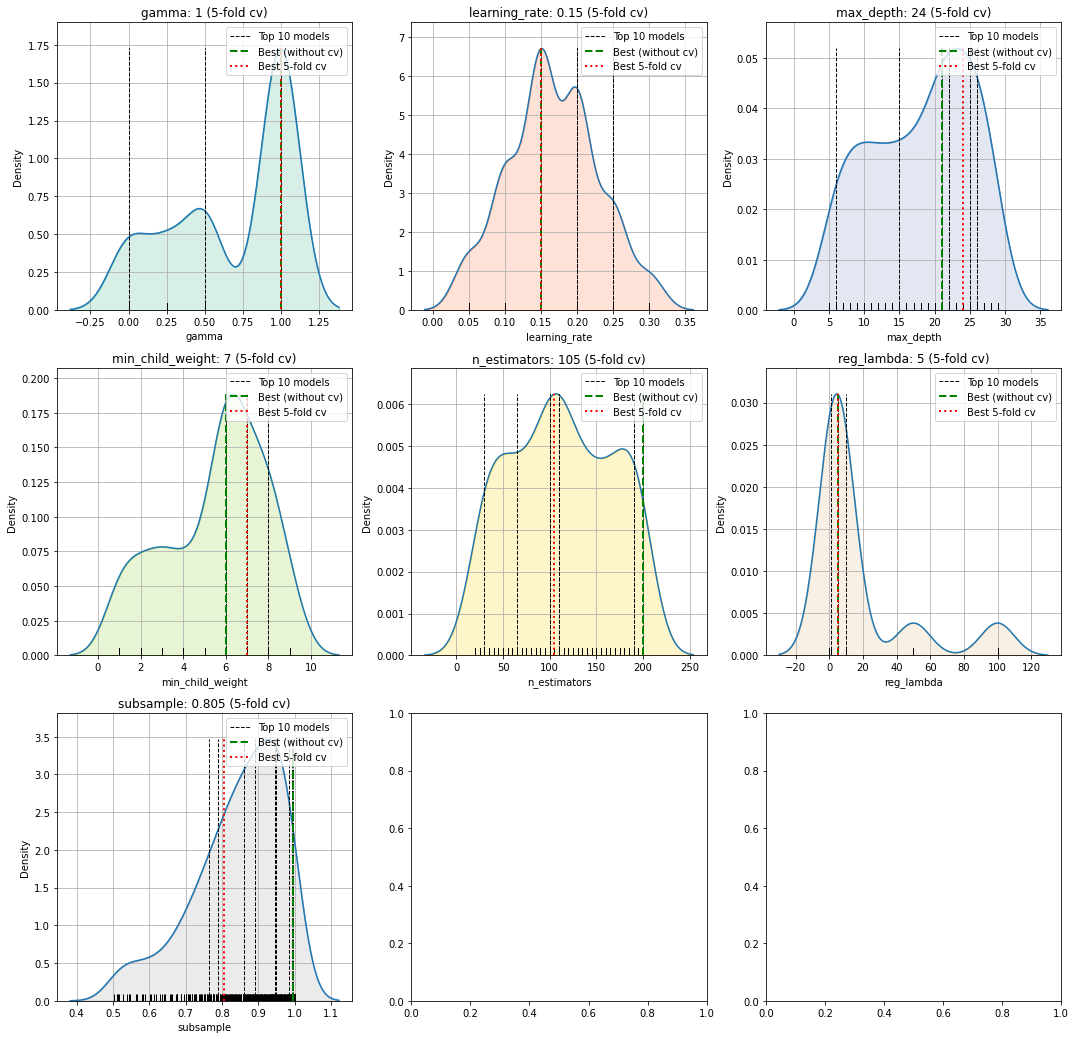

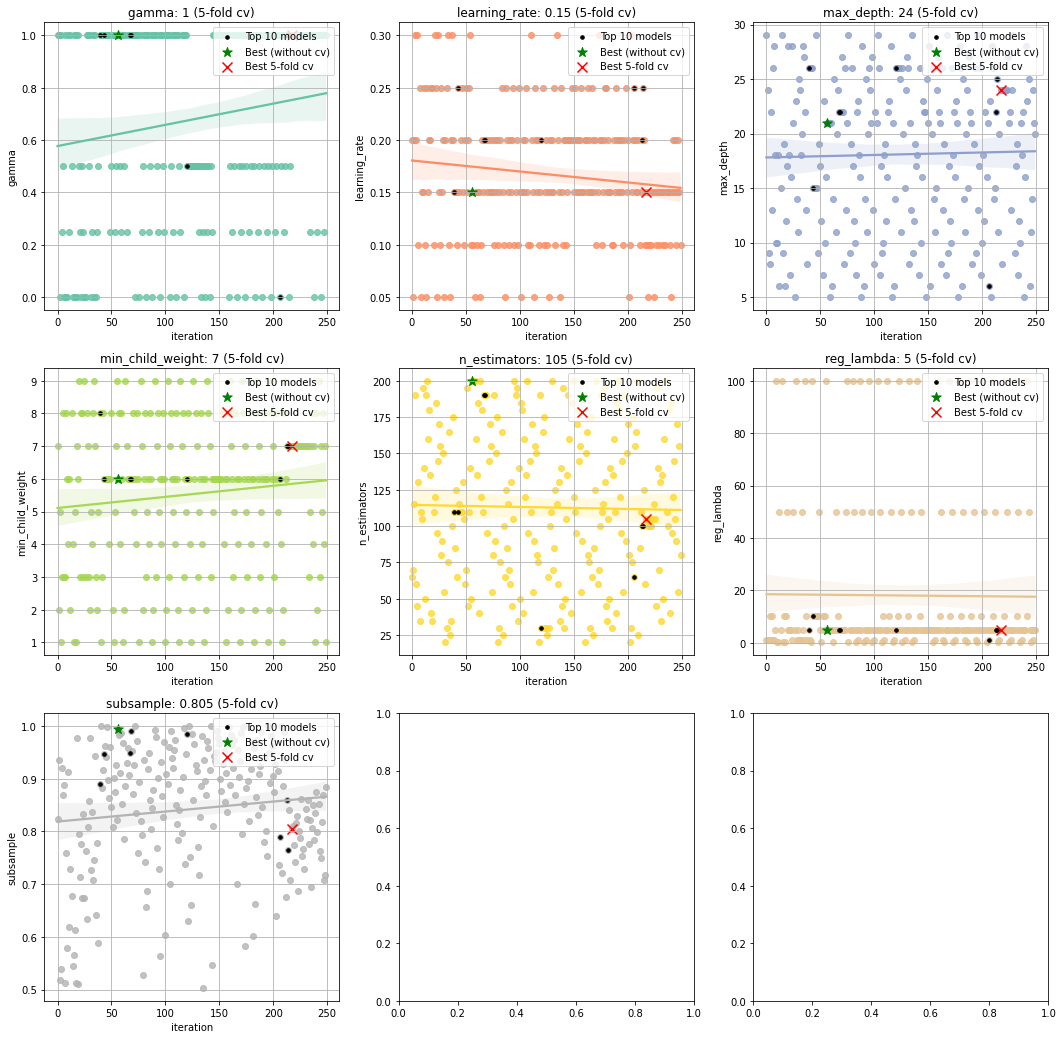

In [49]:
# Plot the parameter space
hgb.plot_params()

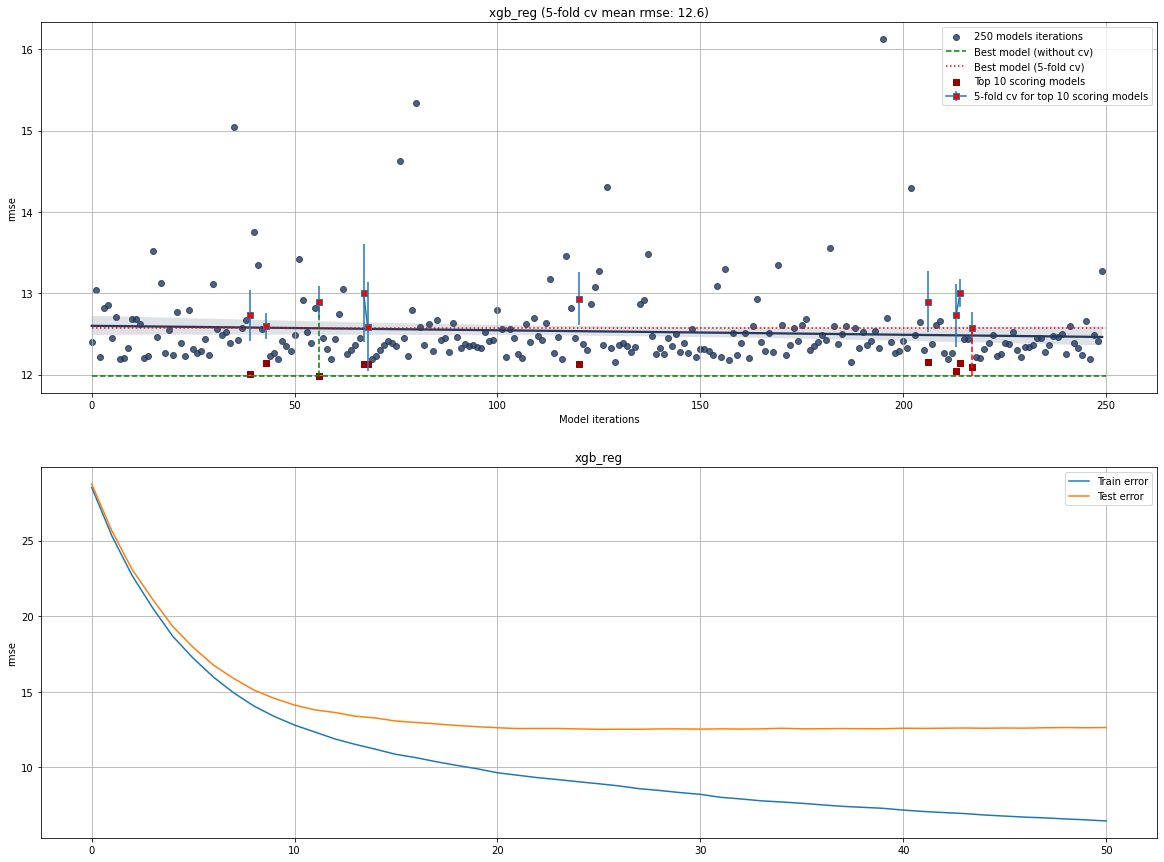

In [50]:
# Plot the summary results
hgb.plot()

[treeplot] >Best detected tree: 104


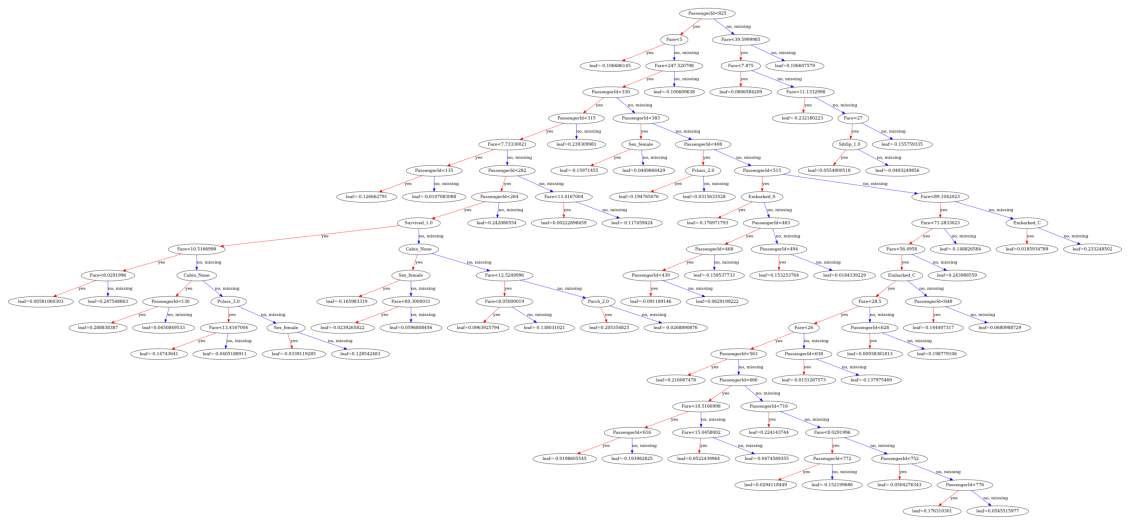

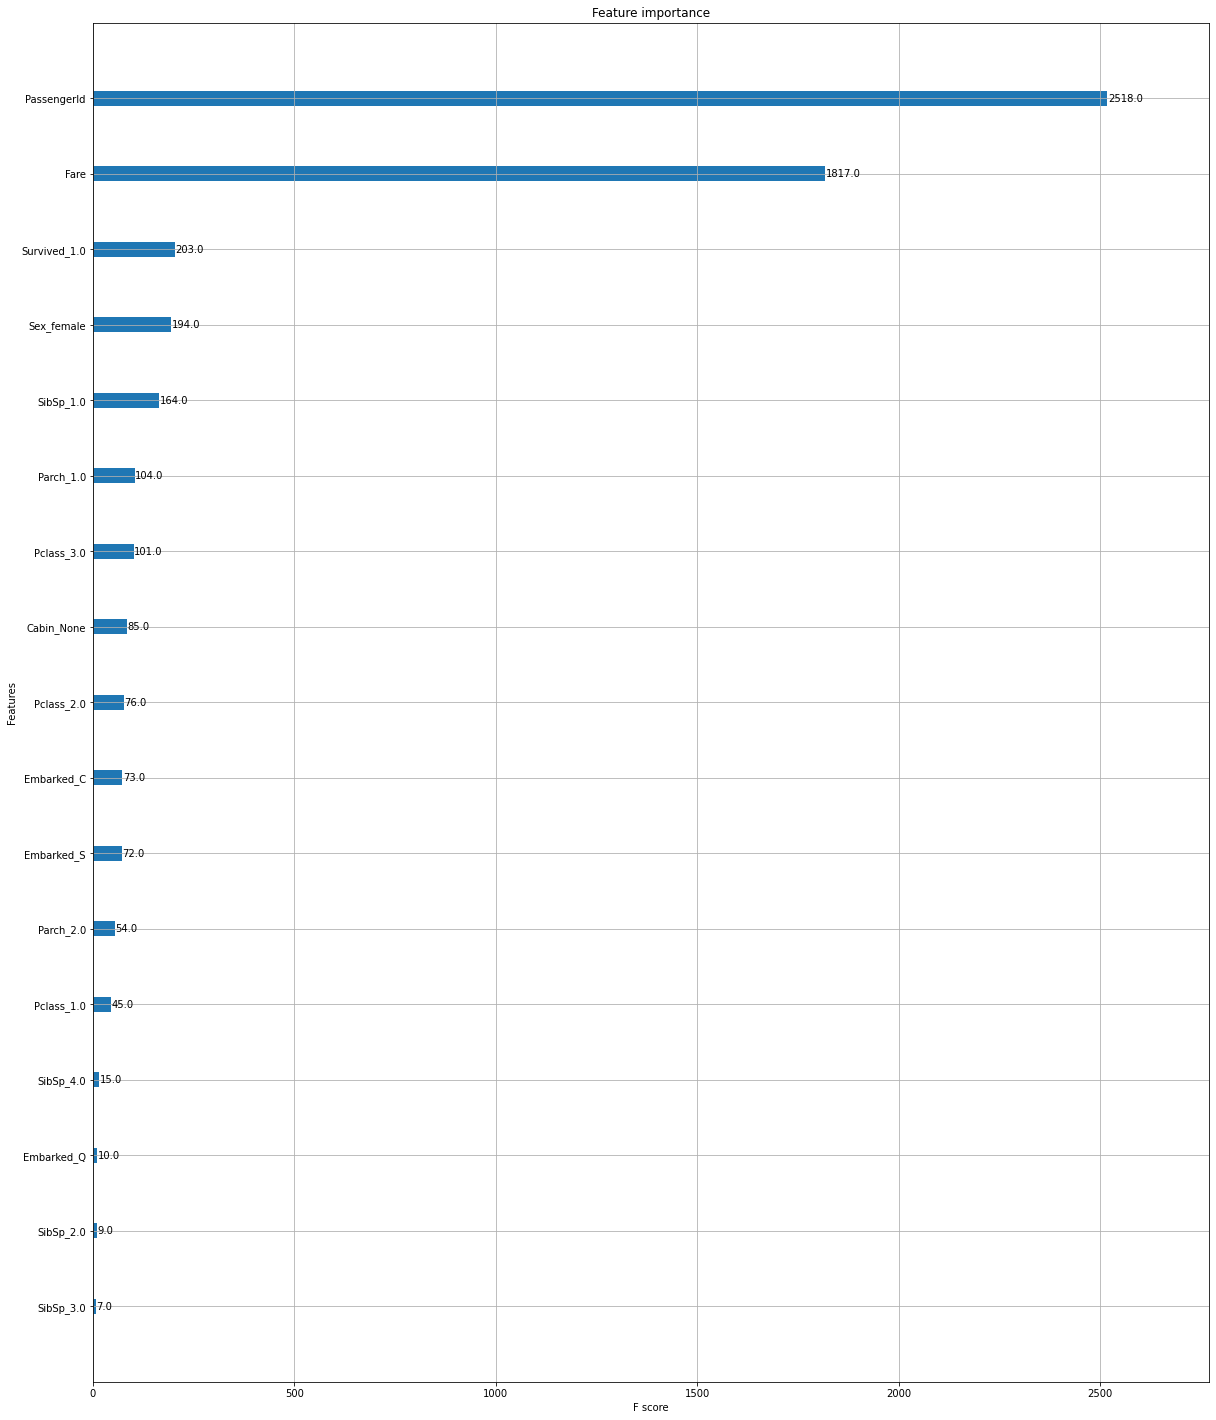

In [51]:
# Plot the best performing tree
hgb.treeplot()

<AxesSubplot:title={'center':'Results on independent validation set'}, xlabel='True value', ylabel='Predicted value'>

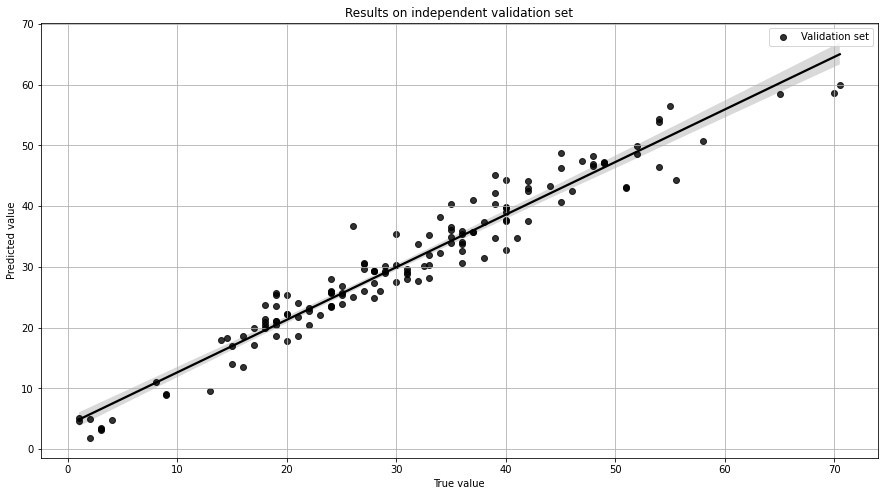

In [52]:
# Plot results on the validation set
hgb.plot_validation()

[hgboost] >5-fold crossvalidation is performed with [xgb_reg]


100%|██████████| 5/5 [00:00<00:00, 43.69it/s]


<AxesSubplot:xlabel='True value', ylabel='Predicted value'>

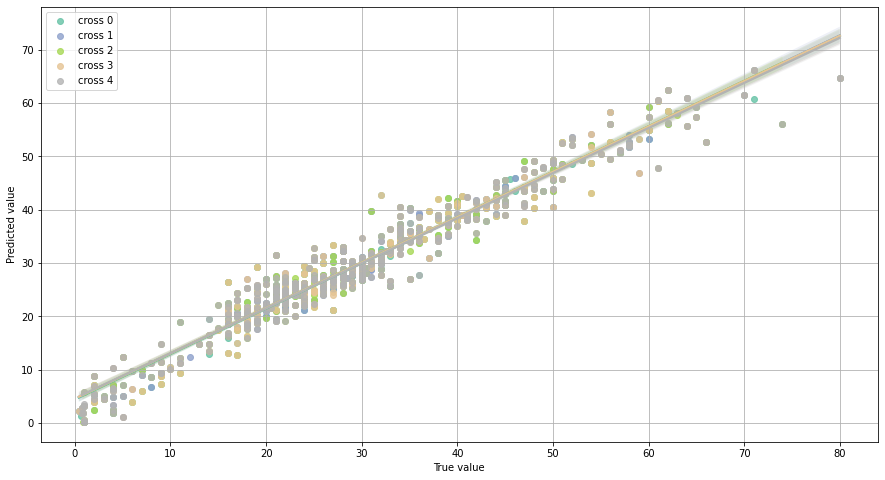

In [53]:
# Plot results on the cross-validation
hgb.plot_cv()

# 2.2 Ensemble Models

In [54]:
# Fit ensemble model for regression task.
hgb.ensemble(X, y, methods=['xgb_reg', 'ctb_reg', 'lgb_reg'])

100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


0:	learn: 14.2479667	total: 790us	remaining: 62.4ms
1:	learn: 13.9442364	total: 1.75ms	remaining: 68.3ms
2:	learn: 13.6183738	total: 2.43ms	remaining: 62.4ms
3:	learn: 13.4955700	total: 3.06ms	remaining: 58.2ms
4:	learn: 13.2553728	total: 3.7ms	remaining: 55.5ms
5:	learn: 13.1387359	total: 4.31ms	remaining: 53.2ms
6:	learn: 13.0013615	total: 4.92ms	remaining: 51.3ms
7:	learn: 12.8100137	total: 5.47ms	remaining: 49.3ms
8:	learn: 12.7309631	total: 6.06ms	remaining: 47.8ms
9:	learn: 12.6852849	total: 6.56ms	remaining: 45.9ms
10:	learn: 12.6031402	total: 7.11ms	remaining: 44.6ms
11:	learn: 12.5591693	total: 7.65ms	remaining: 43.3ms
12:	learn: 12.5129706	total: 8.3ms	remaining: 42.8ms
13:	learn: 12.4695453	total: 8.91ms	remaining: 42ms
14:	learn: 12.4037597	total: 9.47ms	remaining: 41ms
15:	learn: 12.3470207	total: 10.1ms	remaining: 40.5ms
16:	learn: 12.3330952	total: 10.7ms	remaining: 39.5ms
17:	learn: 12.3118300	total: 11.2ms	remaining: 38.7ms
18:	learn: 12.2232410	total: 11.8ms	remaining

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


{'xgb_reg': {'model': <hgboost.hgboost.hgboost at 0x7f4415dfe210>,
  'loss': 12.921025251173063,
  'val_results': None},
 'ctb_reg': {'model': <hgboost.hgboost.hgboost at 0x7f446448b4d0>,
  'loss': 11.250221089261082,
  'val_results': None},
 'lgb_reg': {'model': <hgboost.hgboost.hgboost at 0x7f445519c450>,
  'loss': 12.719215134325893,
  'val_results': None},
 'val_results': None,
 'model': VotingRegressor(estimators=[('xgb_reg',
                              XGBRegressor(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=1.0, gpu_id=0,
                                           grow_policy='dept